# Normal Data Notebook

This notebook is collection of all the stuff that we tried during researching and working with the normal data(the data without baseline normalization).
<br> <b>Disclamer: Feature selection and hyperparamether optimization is not present in this notebook. Plus these stuff aren't helping too much to have a better results in the end.

In [ ]:
# Module for Auto Visualization
!pip install AutoViz

In [1]:
# Loading all the modules that I will use in this notebook
from itertools import product

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from autoviz.AutoViz_Class import AutoViz_Class

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

import cudf, cuml

import lightgbm as lgb

from xgboost import XGBRegressor
from cuml.neighbors import KNeighborsRegressor as knnCMR
from cuml.ensemble import RandomForestRegressor as rfCMR

from xgboost import XGBClassifier
from cuml.neighbors import KNeighborsClassifier as knnCMC
from cuml.ensemble import RandomForestClassifier as rfCMC

from cuml.svm import SVC
from cuml.linear_model import LogisticRegression
from cuml.multiclass import OneVsRestClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor

## 1. Load Data

In [2]:
# Loading the train, test and validation data(datasets) + looking the first 5 rows of the train dataset as confirmation that the data is loaded
train = pd.read_csv('../input/classification/classification/train/videos_emg_features_05_01_train.csv')
validation = pd.read_csv('../input/classification/classification/validation/videos_emg_features_05_01_validation.csv')
test = pd.read_csv('../input/classification/classification/test/videos_emg_features_05_01_test.csv')
train.head()

,Subject,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,...,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,video,arousal,valence,class
0,Subject 26,0.000178,3.184661e-07,-0.043520,0.161232,-0.212268,0.228554,0.043520,-0.185033,0.104441,...,1.342110e-15,3.368695e-13,-86218.958346,-86218.958346,-0.014856,1.377585e-07,GroupA\01,4,5,neutral
1,Subject 26,0.000162,2.598283e-07,0.024016,0.083687,-0.115319,0.209899,-0.024016,-0.092173,0.071753,...,1.118638e-15,2.807781e-13,-83722.723328,-83722.723328,-0.018930,1.184581e-07,GroupA\01,4,5,neutral
2,Subject 26,0.000130,1.856267e-07,0.039356,0.046684,-0.054038,0.186081,-0.039356,-0.050375,0.035060,...,1.150659e-15,2.888153e-13,-66501.839605,-66501.839605,-0.007971,1.015204e-07,GroupA\01,4,5,neutral
3,Subject 26,0.000129,1.931239e-07,0.056126,0.036243,-0.053642,0.165240,-0.056126,-0.038258,0.039529,...,1.033205e-15,2.593346e-13,-66515.135789,-66515.135789,-0.009963,8.059755e-08,GroupA\01,4,5,neutral
4,Subject 26,0.000151,2.156509e-07,0.048009,0.063722,-0.051171,0.181816,-0.048009,-0.068797,0.025145,...,1.064508e-15,2.671916e-13,-75919.081446,-75919.081446,-0.015845,7.440904e-08,GroupA\01,4,5,neutral


## 2. Basic Data Exploration

In [46]:
# Basic info about the size(rows+colums) of the dataset, the memory usage and the datatypes of the data in the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142596 entries, 0 to 142595
Columns: 243 entries, Subject to class
dtypes: float64(238), int64(2), object(3)
memory usage: 264.4+ MB


In [47]:
# Basic info about the size(rows+colums) of the dataset, the memory usage and the datatypes of the data in the validation dataset
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34022 entries, 0 to 34021
Columns: 243 entries, Subject to class
dtypes: float64(238), int64(2), object(3)
memory usage: 63.1+ MB


In [48]:
# Basic info about the size(rows+colums) of the dataset, the memory usage and the datatypes of the data in the test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30791 entries, 0 to 30790
Columns: 243 entries, Subject to class
dtypes: float64(238), int64(2), object(3)
memory usage: 57.1+ MB


In [49]:
# The names of the columns(features) of the train dataset(basically they are same for the train, validation and test datasets)
print(train.columns.to_list())

['Subject', '0_iav', '0_aac', '0_ar1', '0_ar2', '0_ar3', '0_ar4', '0_cc1', '0_cc2', '0_cc3', '0_cc4', '0_dasdv', '0_kurt', '0_log', '0_mav1', '0_mav2', '0_mav', '0_mhw', '0_mtw', '0_rms', '0_skew', '0_ssi', '0_tm', '0_var', '0_v_order', '0_wl', '0_mnf', '0_mdf', '0_pkf', '0_mnp', '0_ttp', '0_vcf', '0_psr', '0_ohm', '0_maxx', '1_iav', '1_aac', '1_ar1', '1_ar2', '1_ar3', '1_ar4', '1_cc1', '1_cc2', '1_cc3', '1_cc4', '1_dasdv', '1_kurt', '1_log', '1_mav1', '1_mav2', '1_mav', '1_mhw', '1_mtw', '1_rms', '1_skew', '1_ssi', '1_tm', '1_var', '1_v_order', '1_wl', '1_mnf', '1_mdf', '1_pkf', '1_mnp', '1_ttp', '1_vcf', '1_psr', '1_ohm', '1_maxx', '2_iav', '2_aac', '2_ar1', '2_ar2', '2_ar3', '2_ar4', '2_cc1', '2_cc2', '2_cc3', '2_cc4', '2_dasdv', '2_kurt', '2_log', '2_mav1', '2_mav2', '2_mav', '2_mhw', '2_mtw', '2_rms', '2_skew', '2_ssi', '2_tm', '2_var', '2_v_order', '2_wl', '2_mnf', '2_mdf', '2_pkf', '2_mnp', '2_ttp', '2_vcf', '2_psr', '2_ohm', '2_maxx', '3_iav', '3_aac', '3_ar1', '3_ar2', '3_ar3'

In [50]:
# The datatypes of each feature
print(train.dtypes.to_list())

[dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'

In [51]:
# All the features which datatype is object(string)
print(train.select_dtypes(include=['object']).columns.to_list())

['Subject', 'video', 'class']


In [52]:
# The shape of the train, validation, test datasets(number of rows + colums)
print(train.shape)
print(validation.shape)
print(test.shape)

(142596, 243)
(34022, 243)
(30791, 243)


In [53]:
# Looking if there are any NaN/Null values in the train dataset
train.isna().sum().sum()

0

In [54]:
# Looking if there are any NaN/Null values in the validation dataset
validation.isna().sum().sum()

0

In [55]:
# Looking if there are any NaN/Null values in the test dataset
test.isna().sum().sum()

0

## 3. EDA, Visualization

In [56]:
# Getting the unique values of the valence column from the train dataset
valences=train["valence"]
unique_valences, num_examples_per_valence = np.unique(valences, return_counts = True)
unique_valences

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [57]:
# Getting the unique values of the class column from the train dataset
classes=train["class"]
unique_classes, num_examples_per_class = np.unique(classes, return_counts = True)
unique_classes

array(['negative', 'neutral', 'positive'], dtype=object)

In [58]:
# Calculating the percentages of how many entries are negative, neutral and positive(from the class)
negative_perc=num_examples_per_class[0]/(num_examples_per_class.sum())*100
positive_perc=num_examples_per_class[2]/(num_examples_per_class.sum())*100
neutral_perc=num_examples_per_class[1]/(num_examples_per_class.sum())*100
print(neutral_perc)
print(positive_perc)
print(negative_perc)

51.89907150270695
21.6990658924514
26.401862604841654


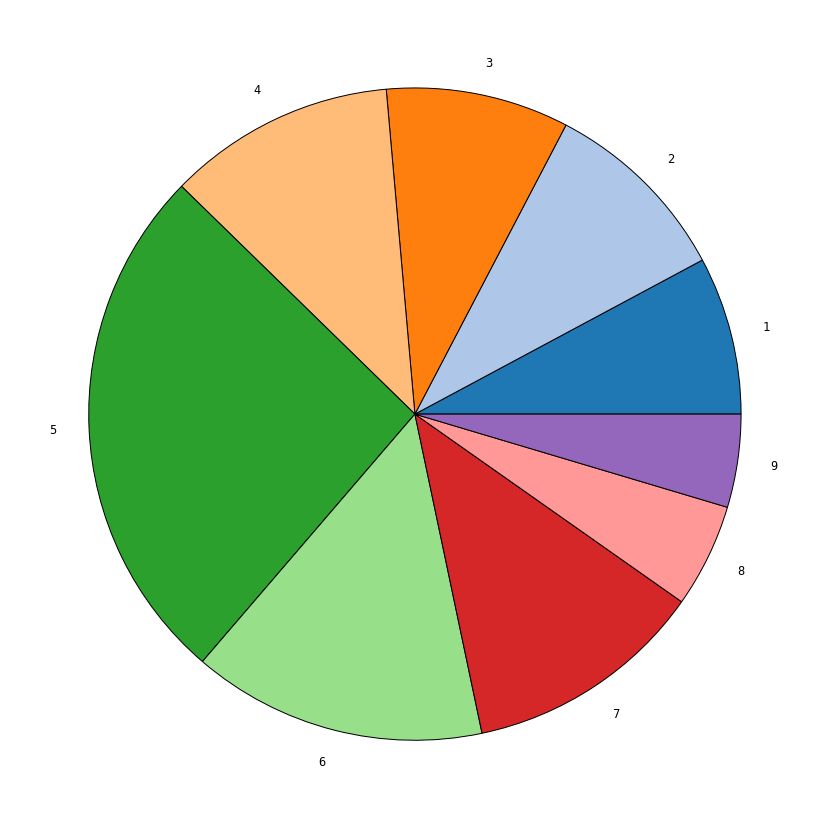

In [59]:
# Plotting the distribution of the valence per entries
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15, 15))

# define the color palette which we will use
cmap = plt.get_cmap("tab20")
# sample as many colors from the palette as there are unique activites, so that each activity will be represented by a different color
sampled_colors = [cmap(i) for i in range (len(num_examples_per_valence))]

# use the pie chart function in the pyplot module to visualize the activity distributions
ax.pie(x = num_examples_per_valence, 
       colors = sampled_colors,
       labels = unique_valences, 
       wedgeprops= {'linewidth': 1, 
                    'edgecolor': 'black'}, 
       textprops = {'size': 'large', 
                    'family': "monospace",
                    'weight': 'medium'} 
);

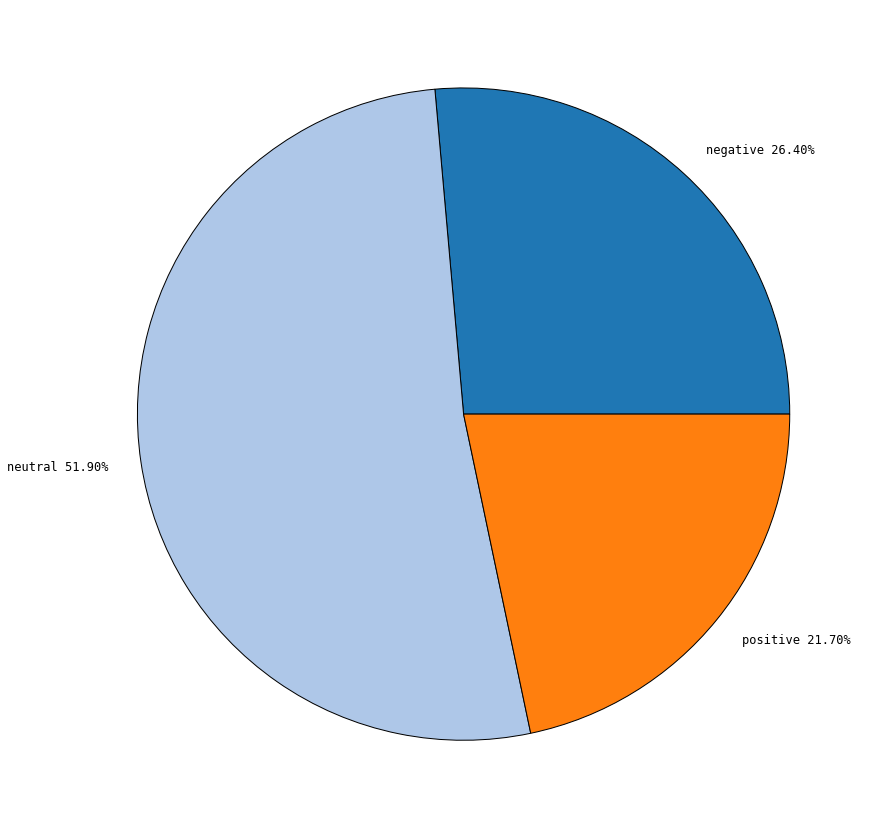

In [60]:
# Plotting the distribution of classes per entry
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15, 15))
# define the color palette which we will use
cmap = plt.get_cmap("tab20")
neg= "{:.2f}".format(negative_perc)
neut= "{:.2f}".format(neutral_perc)
pos = "{:.2f}".format(positive_perc)
my_labels=['','','']
my_labels[0]=unique_classes[0]+" "+str(neg)+"%"
my_labels[1]=unique_classes[1]+" "+str(neut)+"%"
my_labels[2]=unique_classes[2]+" "+str(pos)+"%"
# sample as many colors from the palette as there are unique activites, so that each activity will be represented by a different color
sampled_colors = [cmap(i) for i in range (len(num_examples_per_class))]
ax.pie(x = num_examples_per_class, 
       colors = sampled_colors,
       labels = my_labels, 
       wedgeprops= {'linewidth': 1, 
                    'edgecolor': 'black'}, 
       textprops = {'size': 'large', 
                    'family': "monospace",
                    'weight': 'medium'} 
);

In [ ]:
# Auto Visualization of the features
AV = AutoViz_Class()
viz = AV.AutoViz('../input/classification/classification/train/videos_emg_features_05_01_train.csv')

## 4. Data Preprocessing + Data Split

In [3]:
# From the train dataset dropping all the columns(info) about the subject, video, arousal, valence
train = train.drop(['Subject' ,'video', 'arousal'], axis = 1)
train.head()

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,valence,class
0,0.000178,3.184661e-07,-0.043520,0.161232,-0.212268,0.228554,0.043520,-0.185033,0.104441,-0.433120,...,-137.849854,-38.453445,1.342110e-15,3.368695e-13,-86218.958346,-86218.958346,-0.014856,1.377585e-07,5,neutral
1,0.000162,2.598283e-07,0.024016,0.083687,-0.115319,0.209899,-0.024016,-0.092173,0.071753,-0.374520,...,-107.129854,53.706555,1.118638e-15,2.807781e-13,-83722.723328,-83722.723328,-0.018930,1.184581e-07,5,neutral
2,0.000130,1.856267e-07,0.039356,0.046684,-0.054038,0.186081,-0.039356,-0.050375,0.035060,-0.306471,...,-148.089854,53.706555,1.150659e-15,2.888153e-13,-66501.839605,-66501.839605,-0.007971,1.015204e-07,5,neutral
3,0.000129,1.931239e-07,0.056126,0.036243,-0.053642,0.165240,-0.056126,-0.038258,0.039529,-0.277746,...,-86.649854,53.706555,1.033205e-15,2.593346e-13,-66515.135789,-66515.135789,-0.009963,8.059755e-08,5,neutral
4,0.000151,2.156509e-07,0.048009,0.063722,-0.051171,0.181816,-0.048009,-0.068797,0.025145,-0.291858,...,-76.409854,43.466555,1.064508e-15,2.671916e-13,-75919.081446,-75919.081446,-0.015845,7.440904e-08,5,neutral


In [4]:
# From train dataset remove every second row with neutral class to basically undersample it
train_no_neutral = train[train["class"] != "neutral"]
train_neutral = train[train["class"] == "neutral"]
train_neutral = train_neutral.iloc[::2,:]
train_under = pd.concat([train_no_neutral, train_neutral])

In [64]:
# Seeing if the train undersampled dataset is okay
train_under

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,valence,class
1425,-0.000059,-1.036992e-07,-0.054061,0.001648,-0.091893,-0.069147,0.054061,-0.002167,0.090674,0.064159,...,-45.689854,84.426555,-1.642886e-16,-4.123644e-14,-5044.325552,-5044.325552,0.004006,-1.450892e-08,8,positive
1426,-0.000071,-1.349660e-07,-0.031998,0.023360,-0.075817,-0.041584,0.031998,-0.026572,0.064956,0.031417,...,-55.929854,84.426555,-1.134881e-16,-2.848552e-14,-15532.008879,-15532.008879,0.002330,2.640986e-09,8,positive
1427,-0.000060,-1.205187e-07,-0.041297,0.070463,-0.072981,-0.009469,0.041297,-0.080807,0.039630,-0.006469,...,-35.449854,-69.173445,-1.506899e-16,-3.782317e-14,-4398.964884,-4398.964884,0.003444,9.167321e-09,8,positive
1428,-0.000059,-1.144399e-07,-0.035109,0.043961,-0.058351,-0.007829,0.035109,-0.050202,0.039067,-0.008720,...,-14.969854,-69.173445,-1.911886e-16,-4.798835e-14,612.948582,612.948582,0.002385,1.045101e-09,8,positive
1429,-0.000066,-1.108408e-07,-0.035689,0.051631,-0.070123,-0.010355,0.035689,-0.058991,0.046165,-0.008493,...,36.230146,2.506555,-2.842338e-16,-7.134267e-14,16220.881162,16220.881162,0.001083,-6.076149e-09,8,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139718,0.000256,3.292045e-07,-0.047147,0.092537,-0.035995,0.383292,0.047147,-0.105354,-0.003605,-0.605533,...,-131.604517,-32.114244,5.144911e-16,1.291373e-13,-55344.039619,-55344.039619,0.010749,8.843681e-08,6,neutral
139720,0.000212,2.836518e-07,0.007930,0.071219,-0.061305,0.384536,-0.007930,-0.080105,0.031233,-0.637101,...,-131.604517,-83.314244,1.970647e-16,4.946323e-14,-41377.312753,-41377.312753,0.016530,3.205913e-08,6,neutral
139722,0.000197,2.599762e-07,0.007858,0.068786,-0.076338,0.385370,-0.007858,-0.077362,0.047100,-0.651964,...,-90.644517,131.725756,-6.430514e-17,-1.614059e-14,-27133.350851,-27133.350851,0.013757,1.827166e-08,6,neutral
139724,0.000174,2.101631e-07,0.000765,0.109968,-0.160012,0.406859,-0.000765,-0.124028,0.104304,-0.737949,...,-59.924517,101.005756,-1.239090e-17,-3.110115e-15,-9810.217996,-9810.217996,0.005868,-5.877859e-09,6,neutral


In [63]:
# Getting the unique values of the class column from the train dataset
classes=train_under["class"]
unique_classes, num_examples_per_class = np.unique(classes, return_counts = True)
unique_classes

array(['negative', 'neutral', 'positive'], dtype=object)

In [65]:
# The neutral class in percentage
neutral_perc=num_examples_per_class[1]/(num_examples_per_class.sum())*100
neutral_perc

35.04304262593164

In [66]:
# The shape of the train(undersampled) data
train_under.shape

(105593, 240)

In [5]:
# From the validation dataset dropping all the columns(info) about the subject, video, arousal, valence
validation = validation.drop(['Subject' ,'video', 'arousal'], axis = 1)
validation.head()

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,valence,class
0,-0.000169,-4.098298e-07,-0.060356,0.047298,0.147317,-0.008989,0.060356,-0.054022,-0.169171,0.064959,...,-54.347199,-309.075322,-8.735187e-17,-2.192532e-14,10452.289503,10452.289503,0.011846,-9.987874e-09,8,positive
1,-0.000141,-3.802300e-07,-0.070874,0.051835,0.222165,0.040910,0.070874,-0.059434,-0.243970,0.018670,...,-218.187199,-309.075322,9.984347e-18,2.506071e-15,27763.523048,27763.523048,0.036112,3.352146e-10,8,positive
2,-0.000144,-3.757562e-07,-0.084546,0.071872,0.215971,0.057898,0.084546,-0.083216,-0.244595,-0.004854,...,-177.227199,-309.075322,1.522556e-17,3.821615e-15,44008.348898,44008.348898,0.035138,9.668015e-09,8,positive
3,-0.000169,-4.161795e-07,0.006791,0.079512,0.134118,0.029853,-0.006791,-0.089954,-0.169243,0.006249,...,-44.107199,-298.835322,-6.914059e-17,-1.735429e-14,44420.768513,44420.768513,0.020813,-6.116931e-09,8,positive
4,-0.000182,-4.401250e-07,0.024188,0.062458,0.158687,0.047232,-0.024188,-0.070336,-0.185811,-0.013414,...,-33.867199,438.444678,-6.811706e-17,-1.709738e-14,27132.481327,27132.481327,0.015002,7.444352e-10,8,positive


In [6]:
# From the test dataset dropping all the columns(info) about the subject, video, arousal, valence
test = test.drop(['Subject' ,'video', 'arousal'], axis = 1)
test.head()

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,valence,class
0,-0.000037,3.367405e-08,0.001367,-0.086367,-0.116219,-0.226394,-0.001367,0.099223,0.162996,0.303384,...,147.831579,15.351579,-1.008898e-16,-2.532334e-14,6392.686888,6392.686888,-0.022298,-9.077232e-09,4,neutral
1,-0.000049,-1.305943e-08,0.020567,-0.091839,-0.112770,-0.198270,-0.020567,0.104707,0.161792,0.254321,...,168.311579,15.351579,-1.258649e-16,-3.159208e-14,18021.302083,18021.302083,-0.022005,-5.601545e-09,4,neutral
2,-0.000085,-7.680120e-08,0.039382,-0.074769,-0.087634,-0.220493,-0.039382,0.084808,0.125708,0.302672,...,158.071579,15.351579,-1.343167e-16,-3.371349e-14,-1806.291597,-1806.291597,-0.027671,-1.806795e-08,4,neutral
3,-0.000088,-1.064329e-07,0.000229,-0.021488,-0.100027,-0.168621,-0.000229,0.025195,0.112178,0.218988,...,199.031579,25.591579,-1.217489e-16,-3.055896e-14,-6582.861480,-6582.861480,-0.034137,-1.273636e-08,4,neutral
4,-0.000097,-1.259941e-07,0.029450,-0.046020,-0.079286,-0.161504,-0.029450,0.052715,0.103023,0.210206,...,168.311579,25.591579,-1.561588e-16,-3.919586e-14,-2012.627914,-2012.627914,-0.030596,-1.440579e-08,4,neutral


In [7]:
# The train data is all the columns except the last column which is the class
X_train = train.iloc[:,:-2]
X_train

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_wl,6_mnf,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx
0,0.000178,3.184661e-07,-0.043520,0.161232,-0.212268,0.228554,0.043520,-0.185033,0.104441,-0.433120,...,-4.691394e-06,-121.613493,-137.849854,-38.453445,1.342110e-15,3.368695e-13,-86218.958346,-86218.958346,-0.014856,1.377585e-07
1,0.000162,2.598283e-07,0.024016,0.083687,-0.115319,0.209899,-0.024016,-0.092173,0.071753,-0.374520,...,-2.198235e-06,-103.376845,-107.129854,53.706555,1.118638e-15,2.807781e-13,-83722.723328,-83722.723328,-0.018930,1.184581e-07
2,0.000130,1.856267e-07,0.039356,0.046684,-0.054038,0.186081,-0.039356,-0.050375,0.035060,-0.306471,...,4.908416e-06,-100.451320,-148.089854,53.706555,1.150659e-15,2.888153e-13,-66501.839605,-66501.839605,-0.007971,1.015204e-07
3,0.000129,1.931239e-07,0.056126,0.036243,-0.053642,0.165240,-0.056126,-0.038258,0.039529,-0.277746,...,7.360909e-07,-94.487335,-86.649854,53.706555,1.033205e-15,2.593346e-13,-66515.135789,-66515.135789,-0.009963,8.059755e-08
4,0.000151,2.156509e-07,0.048009,0.063722,-0.051171,0.181816,-0.048009,-0.068797,0.025145,-0.291858,...,5.374088e-07,-96.068424,-76.409854,43.466555,1.064508e-15,2.671916e-13,-75919.081446,-75919.081446,-0.015845,7.440904e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142591,0.000094,1.112939e-07,-0.098656,0.063347,0.029774,0.171195,0.098656,-0.072003,-0.054811,-0.244647,...,-1.968631e-07,44.360198,114.155483,-32.114244,3.072567e-16,7.712143e-14,-35193.391144,-35193.391144,-0.029496,2.397397e-08
142592,0.000106,9.953773e-08,-0.084092,0.062991,0.020209,0.219874,0.084092,-0.071479,-0.045229,-0.323285,...,-1.810208e-06,30.668089,62.955483,60.045756,2.760531e-16,6.928934e-14,-19437.455821,-19437.455821,-0.018619,3.858723e-08
142593,0.000111,1.057361e-07,-0.125625,0.080530,-0.007418,0.211533,0.125625,-0.092727,-0.026013,-0.322026,...,-2.660522e-06,10.406138,32.235483,-32.114244,3.486153e-16,8.750244e-14,-21124.657177,-21124.657177,-0.014149,4.731523e-08
142594,0.000104,1.069753e-07,-0.148270,0.100922,-0.025598,0.213519,0.148270,-0.117679,-0.018313,-0.329656,...,-4.552022e-06,12.943469,-18.964517,-114.034244,2.915351e-16,7.317531e-14,-527.421586,-527.421586,-0.004564,3.701998e-09


In [8]:
# The target for the train data is  before the last column
y_train = train.iloc[:,-2]
y_train

0         5
1         5
2         5
3         5
4         5
         ..
142591    9
142592    9
142593    9
142594    9
142595    9
Name: valence, Length: 142596, dtype: int64

In [9]:
# The class for the train data is the last column
pred_train = train.iloc[:,-1]
pred_train

0          neutral
1          neutral
2          neutral
3          neutral
4          neutral
            ...   
142591    positive
142592    positive
142593    positive
142594    positive
142595    positive
Name: class, Length: 142596, dtype: object

In [10]:
# The train data(undersampled) is all the columns except the last column which is the class
X_train_under = train_under.iloc[:,:-2]
X_train_under

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_wl,6_mnf,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx
1425,-0.000059,-1.036992e-07,-0.054061,0.001648,-0.091893,-0.069147,0.054061,-0.002167,0.090674,0.064159,...,4.336501e-07,-22.064843,-45.689854,84.426555,-1.642886e-16,-4.123644e-14,-5044.325552,-5044.325552,0.004006,-1.450892e-08
1426,-0.000071,-1.349660e-07,-0.031998,0.023360,-0.075817,-0.041584,0.031998,-0.026572,0.064956,0.031417,...,1.534546e-06,-35.125680,-55.929854,84.426555,-1.134881e-16,-2.848552e-14,-15532.008879,-15532.008879,0.002330,2.640986e-09
1427,-0.000060,-1.205187e-07,-0.041297,0.070463,-0.072981,-0.009469,0.041297,-0.080807,0.039630,-0.006469,...,1.137351e-06,-19.255200,-35.449854,-69.173445,-1.506899e-16,-3.782317e-14,-4398.964884,-4398.964884,0.003444,9.167321e-09
1428,-0.000059,-1.144399e-07,-0.035109,0.043961,-0.058351,-0.007829,0.035109,-0.050202,0.039067,-0.008720,...,2.787986e-06,-7.458505,-14.969854,-69.173445,-1.911886e-16,-4.798835e-14,612.948582,612.948582,0.002385,1.045101e-09
1429,-0.000066,-1.108408e-07,-0.035689,0.051631,-0.070123,-0.010355,0.035689,-0.058991,0.046165,-0.008493,...,8.754477e-07,22.843478,36.230146,2.506555,-2.842338e-16,-7.134267e-14,16220.881162,16220.881162,0.001083,-6.076149e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139718,0.000256,3.292045e-07,-0.047147,0.092537,-0.035995,0.383292,0.047147,-0.105354,-0.003605,-0.605533,...,-9.839916e-07,-131.794910,-131.604517,-32.114244,5.144911e-16,1.291373e-13,-55344.039619,-55344.039619,0.010749,8.843681e-08
139720,0.000212,2.836518e-07,0.007930,0.071219,-0.061305,0.384536,-0.007930,-0.080105,0.031233,-0.637101,...,-7.840023e-07,-122.127351,-131.604517,-83.314244,1.970647e-16,4.946323e-14,-41377.312753,-41377.312753,0.016530,3.205913e-08
139722,0.000197,2.599762e-07,0.007858,0.068786,-0.076338,0.385370,-0.007858,-0.077362,0.047100,-0.651964,...,4.227782e-07,-89.989946,-90.644517,131.725756,-6.430514e-17,-1.614059e-14,-27133.350851,-27133.350851,0.013757,1.827166e-08
139724,0.000174,2.101631e-07,0.000765,0.109968,-0.160012,0.406859,-0.000765,-0.124028,0.104304,-0.737949,...,-7.793287e-07,-37.303650,-59.924517,101.005756,-1.239090e-17,-3.110115e-15,-9810.217996,-9810.217996,0.005868,-5.877859e-09


In [11]:
# The target for the train data(undersampled) is  before the last column
y_train_under = train_under.iloc[:,-2]
y_train_under

1425      8
1426      8
1427      8
1428      8
1429      8
         ..
139718    6
139720    6
139722    6
139724    6
139726    6
Name: valence, Length: 105593, dtype: int64

In [12]:
# The class for the train data(undersampled) is the last column
pred_train_under = train_under.iloc[:,-1]
pred_train_under

1425      positive
1426      positive
1427      positive
1428      positive
1429      positive
            ...   
139718     neutral
139720     neutral
139722     neutral
139724     neutral
139726     neutral
Name: class, Length: 105593, dtype: object

In [13]:
# The validation data is all the columns except the last 2 columns which are the target + class 
X_validation = validation.iloc[:,:-2]
X_validation

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_wl,6_mnf,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx
0,-0.000169,-4.098298e-07,-0.060356,0.047298,0.147317,-0.008989,0.060356,-0.054022,-0.169171,0.064959,...,-2.545709e-06,-47.326305,-54.347199,-309.075322,-8.735187e-17,-2.192532e-14,10452.289503,10452.289503,0.011846,-9.987874e-09
1,-0.000141,-3.802300e-07,-0.070874,0.051835,0.222165,0.040910,0.070874,-0.059434,-0.243970,0.018670,...,-2.550875e-06,-124.319607,-218.187199,-309.075322,9.984347e-18,2.506071e-15,27763.523048,27763.523048,0.036112,3.352146e-10
2,-0.000144,-3.757562e-07,-0.084546,0.071872,0.215971,0.057898,0.084546,-0.083216,-0.244595,-0.004854,...,1.993151e-06,-93.439613,-177.227199,-309.075322,1.522556e-17,3.821615e-15,44008.348898,44008.348898,0.035138,9.668015e-09
3,-0.000169,-4.161795e-07,0.006791,0.079512,0.134118,0.029853,-0.006791,-0.089954,-0.169243,0.006249,...,2.298806e-06,-29.491657,-44.107199,-298.835322,-6.914059e-17,-1.735429e-14,44420.768513,44420.768513,0.020813,-6.116931e-09
4,-0.000182,-4.401250e-07,0.024188,0.062458,0.158687,0.047232,-0.024188,-0.070336,-0.185811,-0.013414,...,7.242016e-08,-31.927312,-33.867199,438.444678,-6.811706e-17,-1.709738e-14,27132.481327,27132.481327,0.015002,7.444352e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34017,0.000161,5.185158e-07,-0.033427,0.005838,-0.185736,-0.094345,0.033427,-0.006066,0.179824,0.059320,...,-4.579695e-06,195.095083,274.366316,195.343158,2.218619e-16,5.568733e-14,16152.988195,16152.988195,-0.035475,2.678931e-08
34018,0.000275,7.454285e-07,-0.026663,0.021879,-0.107233,-0.041092,0.026663,-0.024526,0.094874,0.009975,...,1.812504e-07,232.291748,284.606316,82.703158,1.241565e-16,3.116329e-14,26197.681460,26197.681460,-0.037842,2.182656e-08
34019,0.000346,9.383774e-07,0.137526,-0.124702,0.132393,-0.100797,-0.137526,0.136485,-0.093855,0.198813,...,5.361315e-06,243.210271,274.366316,246.543158,6.307591e-17,1.583205e-14,15459.144802,15459.144802,-0.043558,2.488220e-08
34020,0.000310,8.272760e-07,0.131100,-0.121561,0.142229,-0.090330,-0.131100,0.133433,-0.105496,0.189737,...,8.713797e-07,230.786402,274.366316,246.543158,-1.597738e-16,-4.010323e-14,36744.836234,36744.836234,-0.033643,8.543828e-09


In [14]:
# The class for the validation data is the last column
y_validation = validation.iloc[:,-2]
y_validation

0        8
1        8
2        8
3        8
4        8
        ..
34017    4
34018    4
34019    4
34020    4
34021    4
Name: valence, Length: 34022, dtype: int64

In [15]:
# The class for the validation data is the last column
pred_validation = validation.iloc[:,-1]
pred_validation

0        positive
1        positive
2        positive
3        positive
4        positive
           ...   
34017     neutral
34018     neutral
34019     neutral
34020     neutral
34021     neutral
Name: class, Length: 34022, dtype: object

In [16]:
# The test data is all the columns except the last 2 columns which are the target + class 
X_test = test.iloc[:,:-2]
X_test

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_wl,6_mnf,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx
0,-0.000037,3.367405e-08,0.001367,-0.086367,-0.116219,-0.226394,-0.001367,0.099223,0.162996,0.303384,...,2.898422e-06,113.224527,147.831579,15.351579,-1.008898e-16,-2.532334e-14,6392.686888,6392.686888,-0.022298,-9.077232e-09
1,-0.000049,-1.305943e-08,0.020567,-0.091839,-0.112770,-0.198270,-0.020567,0.104707,0.161792,0.254321,...,-6.899484e-07,134.373149,168.311579,15.351579,-1.258649e-16,-3.159208e-14,18021.302083,18021.302083,-0.022005,-5.601545e-09
2,-0.000085,-7.680120e-08,0.039382,-0.074769,-0.087634,-0.220493,-0.039382,0.084808,0.125708,0.302672,...,2.505873e-06,126.395475,158.071579,15.351579,-1.343167e-16,-3.371349e-14,-1806.291597,-1806.291597,-0.027671,-1.806795e-08
3,-0.000088,-1.064329e-07,0.000229,-0.021488,-0.100027,-0.168621,-0.000229,0.025195,0.112178,0.218988,...,2.172300e-06,154.837829,199.031579,25.591579,-1.217489e-16,-3.055896e-14,-6582.861480,-6582.861480,-0.034137,-1.273636e-08
4,-0.000097,-1.259941e-07,0.029450,-0.046020,-0.079286,-0.161504,-0.029450,0.052715,0.103023,0.210206,...,1.913080e-06,142.995455,168.311579,25.591579,-1.561588e-16,-3.919586e-14,-2012.627914,-2012.627914,-0.030596,-1.440579e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30786,-0.000062,-1.355511e-07,0.063291,-0.048189,0.013044,-0.090411,-0.063291,0.052234,0.008427,0.145268,...,3.305718e-07,-17.014195,-19.789872,-294.815009,-5.362504e-17,-1.345989e-14,9725.693389,9725.693389,0.006284,-1.814013e-08
30787,-0.000052,-1.256089e-07,0.086627,-0.005964,-0.011104,-0.038151,-0.086627,0.005174,0.015375,0.057111,...,3.031704e-06,-31.176277,-19.789872,-294.815009,-2.841139e-17,-7.131259e-15,14121.385317,14121.385317,0.010708,-2.233756e-08
30788,-0.000025,-6.995057e-08,0.090014,0.001493,-0.082924,-0.018126,-0.090014,-0.003018,0.087261,0.003610,...,-3.159924e-07,-82.882242,-111.949872,-284.575009,-2.071889e-18,-5.200440e-16,697.097461,697.097461,0.016454,-3.479612e-09
30789,-0.000038,-9.252400e-08,0.074360,-0.010191,-0.077144,-0.019843,-0.074360,0.010122,0.087571,0.006566,...,-1.974122e-06,-83.108477,-111.949872,-130.975009,6.676131e-18,1.675709e-15,17279.908426,17279.908426,0.023264,3.795017e-09


In [17]:
# The target for the test data is  before the last column
y_test = test.iloc[:,-2]
y_test

0        4
1        4
2        4
3        4
4        4
        ..
30786    5
30787    5
30788    5
30789    5
30790    5
Name: valence, Length: 30791, dtype: int64

In [18]:
# The class for the test data is the last column
pred_test = test.iloc[:,-1]
pred_test

0        neutral
1        neutral
2        neutral
3        neutral
4        neutral
          ...   
30786    neutral
30787    neutral
30788    neutral
30789    neutral
30790    neutral
Name: class, Length: 30791, dtype: object

In [19]:
# Scaling all the data between -1 and 1 for the train, validation and test
stardard_scaler = StandardScaler()
X_train_st = stardard_scaler.fit_transform(X_train)
X_train_under_st = stardard_scaler.transform(X_train_under)
X_validation_st = stardard_scaler.transform(X_validation)
X_test_st = stardard_scaler.transform(X_test)

In [20]:
# Scalling all the data between the min and the max value for the train, validation and test
minmax_scaler = MinMaxScaler()
X_train_mm = minmax_scaler.fit_transform(X_train)
X_train_under_mm = minmax_scaler.transform(X_train_under)
X_validation_mm = minmax_scaler.transform(X_validation)
X_test_mm = minmax_scaler.transform(X_test)

In [21]:
# Encoding the classes 
encoder = LabelEncoder()
pred_train = encoder.fit_transform(pred_train)
pred_train_under = encoder.transform(pred_train_under)
pred_validation = encoder.transform(pred_validation)
pred_test = encoder.transform(pred_test)

## 5. Functions and other stuff for working with ML models

In [22]:
# Defining a dictionary which will be used for mapping the results of the regression
dict = {1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:2, 8:2, 9:2}

In [23]:
def con_matrix(y_true, pred):
    cf = confusion_matrix(y_true, pred)
    sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues')

In [24]:
# Scoring the quasi classification of the model
def score_classification(y_true, pred):
    pred = np.array(list(map(lambda x: dict[x], pred)))
    f1_macro = f1_score(y_true, pred,average='macro')                       
    print(classification_report(y_true, pred))
    print("--------------------")
    print(f'The accuracy of the model is: {accuracy_score(y_true, pred)}')
    print("--------------------")
    print(f'The f1-macro score for the model is: {f1_macro}')
    print("--------------------")
    con_matrix(y_true,pred)

In [25]:
# Scoring the regression model
def score_regression(y_validation, pred):
    print(f'Mean absolute error:  {mean_absolute_error(y_validation, pred)}')
    print("--------------------")
    print(f'Mean squared error: {mean_squared_error(y_validation, pred)}')
    print("--------------------")
    print(f'Root mean squared error: {np.sqrt(mean_squared_error(y_validation, pred))}')
    print("--------------------")
    print(f'R2 score: {r2_score(y_validation,pred)}')
    print("--------------------")

In [26]:
# Score the pure classification model
def score_pure_classification(y_true, pred):
    f1_macro = f1_score(y_true, pred,average='macro')                       
    print(classification_report(y_true, pred))
    print("--------------------")
    print(f'The accuracy of the model is: {accuracy_score(y_true, pred)}')
    print("--------------------")
    print(f'The f1-macro score for the model is: {f1_macro}')
    print("--------------------")
    con_matrix(y_true,pred)

In [27]:
# Transforming the regression data
def transformData(pred):
    pred = np.floor(pred)
    pred[pred > 9] = 9
    pred[pred <= 0] = 1
    return pred

## 5.1 Classification with 3 classes

### 5.1.1 Random Forest Model

<b> Non-changed data

In [130]:
rfc1 = rfCMC(n_estimators=500, n_bins = 256, split_criterion= 1)
rfc1.fit(X_train, pred_train)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


RandomForestClassifier()

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.47      0.35      0.40      5552
           1       0.77      0.77      0.77     23230
           2       0.33      0.42      0.37      5240

    accuracy                           0.65     34022
   macro avg       0.53      0.51      0.51     34022
weighted avg       0.66      0.65      0.65     34022

--------------------
The accuracy of the model is: 0.6496678619716654
--------------------
The f1-macro score for the model is: 0.5142354483591802
--------------------


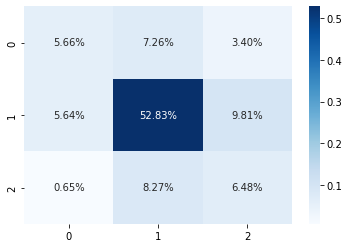

In [131]:
pred = rfc1.predict(X_validation)
score_pure_classification(pred_validation, pred)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.20      0.15      0.17      7117
           1       0.68      0.71      0.69     19330
           2       0.49      0.58      0.53      4344

    accuracy                           0.56     30791
   macro avg       0.45      0.48      0.46     30791
weighted avg       0.54      0.56      0.55     30791

--------------------
The accuracy of the model is: 0.56370367964665
--------------------
The f1-macro score for the model is: 0.46448124268815133
--------------------


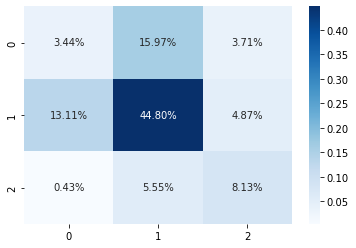

In [132]:
pred = rfc1.predict(X_test)
score_pure_classification(pred_test, pred)

<b> Non-changed data standard scaled

In [133]:
rfc2 = rfCMC(n_estimators=500, n_bins = 256, split_criterion= 1)
rfc2.fit(X_train_st, pred_train)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


RandomForestClassifier()

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.47      0.35      0.40      5552
           1       0.77      0.77      0.77     23230
           2       0.33      0.42      0.37      5240

    accuracy                           0.65     34022
   macro avg       0.53      0.51      0.51     34022
weighted avg       0.66      0.65      0.65     34022

--------------------
The accuracy of the model is: 0.6496678619716654
--------------------
The f1-macro score for the model is: 0.5142354483591802
--------------------


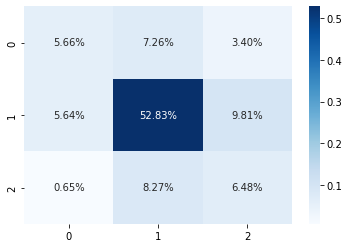

In [134]:
pred = rfc2.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.20      0.15      0.17      7117
           1       0.68      0.71      0.69     19330
           2       0.49      0.58      0.53      4344

    accuracy                           0.56     30791
   macro avg       0.45      0.48      0.46     30791
weighted avg       0.54      0.56      0.55     30791

--------------------
The accuracy of the model is: 0.56370367964665
--------------------
The f1-macro score for the model is: 0.46448124268815133
--------------------


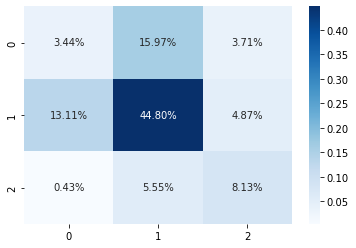

In [135]:
pred = rfc2.predict(X_test_st)
score_pure_classification(pred_test, pred)

<b> Non-changed data minmax scaled

In [137]:
rfc3 = rfCMC(n_estimators=500, n_bins = 256, split_criterion= 1)
rfc3.fit(X_train_mm, pred_train)

RandomForestClassifier()

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.47      0.35      0.40      5552
           1       0.77      0.77      0.77     23230
           2       0.33      0.42      0.37      5240

    accuracy                           0.65     34022
   macro avg       0.53      0.51      0.51     34022
weighted avg       0.66      0.65      0.65     34022

--------------------
The accuracy of the model is: 0.6496678619716654
--------------------
The f1-macro score for the model is: 0.5142354483591802
--------------------


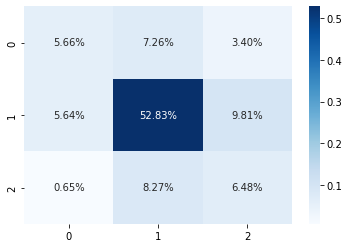

In [138]:
pred = rfc3.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.20      0.15      0.17      7117
           1       0.68      0.71      0.69     19330
           2       0.49      0.58      0.53      4344

    accuracy                           0.56     30791
   macro avg       0.45      0.48      0.46     30791
weighted avg       0.54      0.56      0.55     30791

--------------------
The accuracy of the model is: 0.56370367964665
--------------------
The f1-macro score for the model is: 0.46448124268815133
--------------------


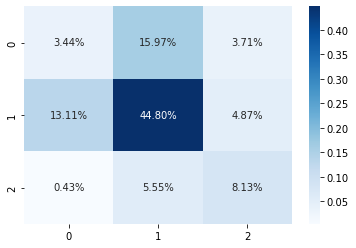

In [139]:
pred = rfc3.predict(X_test_mm)
score_pure_classification(pred_test, pred)

<b> Undersampled data

In [140]:
rfc4 = rfCMC(n_estimators=500, n_bins = 256, split_criterion= 1)
rfc4.fit(X_train_under, pred_train_under)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


RandomForestClassifier()

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.37      0.52      0.44      5552
           1       0.82      0.64      0.72     23230
           2       0.33      0.51      0.41      5240

    accuracy                           0.60     34022
   macro avg       0.51      0.56      0.52     34022
weighted avg       0.67      0.60      0.62     34022

--------------------
The accuracy of the model is: 0.6021397918993593
--------------------
The f1-macro score for the model is: 0.5199743734920369
--------------------


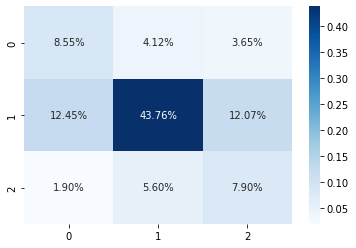

In [141]:
pred = rfc4.predict(X_validation)
score_pure_classification(pred_validation, pred)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.24      0.27      0.25      7117
           1       0.69      0.59      0.63     19330
           2       0.44      0.63      0.52      4344

    accuracy                           0.52     30791
   macro avg       0.46      0.50      0.47     30791
weighted avg       0.55      0.52      0.53     30791

--------------------
The accuracy of the model is: 0.5196648371277321
--------------------
The f1-macro score for the model is: 0.46806504001093124
--------------------


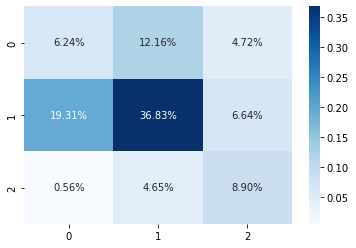

In [142]:
pred = rfc4.predict(X_test)
score_pure_classification(pred_test, pred)

<b> Undersampled data standard scaled

In [143]:
rfc5 = rfCMC(n_estimators=500, n_bins = 256, split_criterion= 1)
rfc5.fit(X_train_under_st, pred_train_under)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


RandomForestClassifier()

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.37      0.52      0.44      5552
           1       0.82      0.64      0.72     23230
           2       0.33      0.51      0.41      5240

    accuracy                           0.60     34022
   macro avg       0.51      0.56      0.52     34022
weighted avg       0.67      0.60      0.62     34022

--------------------
The accuracy of the model is: 0.6021397918993593
--------------------
The f1-macro score for the model is: 0.5199743734920369
--------------------


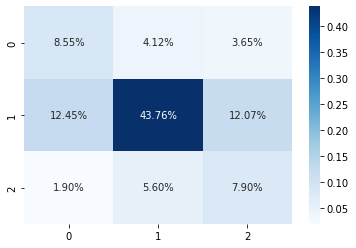

In [144]:
pred = rfc5.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.24      0.27      0.25      7117
           1       0.69      0.59      0.63     19330
           2       0.44      0.63      0.52      4344

    accuracy                           0.52     30791
   macro avg       0.46      0.50      0.47     30791
weighted avg       0.55      0.52      0.53     30791

--------------------
The accuracy of the model is: 0.5196648371277321
--------------------
The f1-macro score for the model is: 0.46806504001093124
--------------------


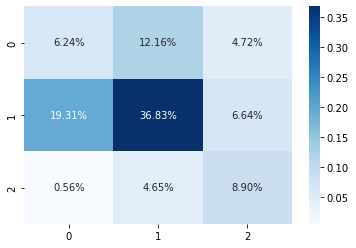

In [146]:
pred = rfc5.predict(X_test_st)
score_pure_classification(pred_test, pred)

<b> Undersampled data minmax scaled

In [147]:
rfc6 = rfCMC(n_estimators=500, n_bins = 256, split_criterion= 1)
rfc6.fit(X_train_under_mm, pred_train_under)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


RandomForestClassifier()

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.37      0.52      0.44      5552
           1       0.82      0.64      0.72     23230
           2       0.33      0.51      0.41      5240

    accuracy                           0.60     34022
   macro avg       0.51      0.56      0.52     34022
weighted avg       0.67      0.60      0.62     34022

--------------------
The accuracy of the model is: 0.6021397918993593
--------------------
The f1-macro score for the model is: 0.5199743734920369
--------------------


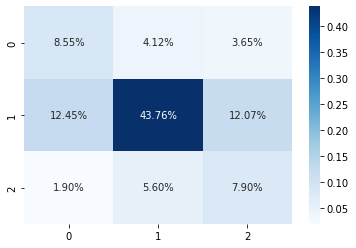

In [148]:
pred = rfc6.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.24      0.27      0.25      7117
           1       0.69      0.59      0.63     19330
           2       0.44      0.63      0.52      4344

    accuracy                           0.52     30791
   macro avg       0.46      0.50      0.47     30791
weighted avg       0.55      0.52      0.53     30791

--------------------
The accuracy of the model is: 0.5196648371277321
--------------------
The f1-macro score for the model is: 0.46806504001093124
--------------------


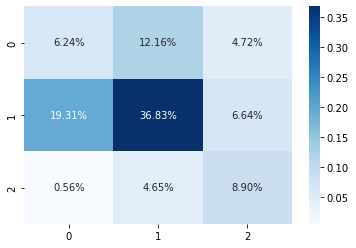

In [149]:
pred = rfc6.predict(X_test_mm)
score_pure_classification(pred_test, pred)

### 5.1.2 XGBoost Model

<b> Non-changed data

In [150]:
xgbc1 = XGBClassifier(tree_method = 'gpu_hist', n_estimators = 500)
xgbc1.fit(X_train, pred_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

              precision    recall  f1-score   support

           0       0.33      0.41      0.36      5552
           1       0.77      0.71      0.74     23230
           2       0.32      0.34      0.33      5240

    accuracy                           0.60     34022
   macro avg       0.47      0.49      0.48     34022
weighted avg       0.63      0.60      0.61     34022

--------------------
The accuracy of the model is: 0.6037857856680972
--------------------
The f1-macro score for the model is: 0.4776581520553544
--------------------


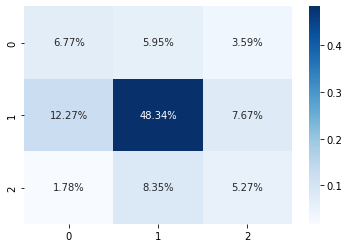

In [151]:
pred = xgbc1.predict(X_validation)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.22      0.24      0.23      7117
           1       0.63      0.58      0.61     19330
           2       0.40      0.47      0.43      4344

    accuracy                           0.49     30791
   macro avg       0.42      0.43      0.42     30791
weighted avg       0.50      0.49      0.50     30791

--------------------
The accuracy of the model is: 0.48812964827384625
--------------------
The f1-macro score for the model is: 0.42226346892640665
--------------------


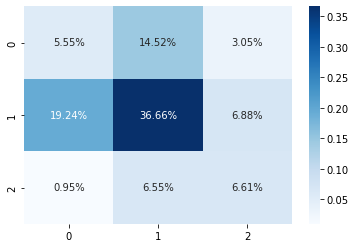

In [152]:
pred = xgbc1.predict(X_test)
score_pure_classification(pred_test, pred)

<b>Non-changed data standard scaled

In [153]:
xgbc2 = XGBClassifier(tree_method = 'gpu_hist', n_estimators = 500)
xgbc2.fit(X_train_st, pred_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

              precision    recall  f1-score   support

           0       0.29      0.32      0.30      5552
           1       0.76      0.71      0.73     23230
           2       0.30      0.35      0.33      5240

    accuracy                           0.59     34022
   macro avg       0.45      0.46      0.46     34022
weighted avg       0.61      0.59      0.60     34022

--------------------
The accuracy of the model is: 0.593645288342837
--------------------
The f1-macro score for the model is: 0.4551999028321239
--------------------


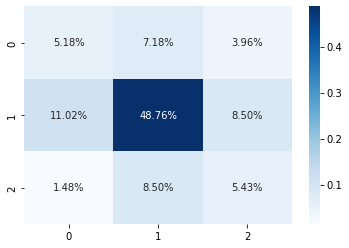

In [154]:
pred = xgbc2.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.23      0.27      0.25      7117
           1       0.62      0.57      0.59     19330
           2       0.36      0.40      0.38      4344

    accuracy                           0.48     30791
   macro avg       0.40      0.41      0.41     30791
weighted avg       0.50      0.48      0.48     30791

--------------------
The accuracy of the model is: 0.47510636224870906
--------------------
The f1-macro score for the model is: 0.4064238043432898
--------------------


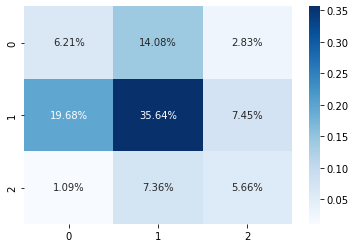

In [155]:
pred = xgbc2.predict(X_test_st)
score_pure_classification(pred_test, pred)

<b>Non-changed data minmax scaled

In [156]:
xgbc3 = XGBClassifier(tree_method = 'gpu_hist', n_estimators = 500)
xgbc3.fit(X_train_mm, pred_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

              precision    recall  f1-score   support

           0       0.28      0.38      0.32      5552
           1       0.77      0.68      0.72     23230
           2       0.32      0.34      0.33      5240

    accuracy                           0.58     34022
   macro avg       0.45      0.47      0.46     34022
weighted avg       0.62      0.58      0.60     34022

--------------------
The accuracy of the model is: 0.5815942625360061
--------------------
The f1-macro score for the model is: 0.4580655092942629
--------------------


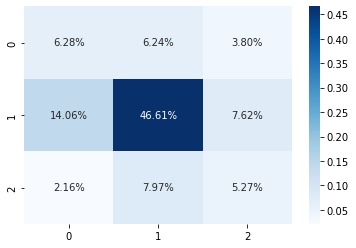

In [157]:
pred = xgbc3.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.23      0.27      0.25      7117
           1       0.62      0.55      0.59     19330
           2       0.36      0.42      0.39      4344

    accuracy                           0.47     30791
   macro avg       0.40      0.42      0.41     30791
weighted avg       0.49      0.47      0.48     30791

--------------------
The accuracy of the model is: 0.46913059010749897
--------------------
The f1-macro score for the model is: 0.40715759815368996
--------------------


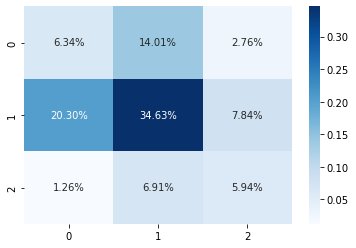

In [158]:
pred = xgbc3.predict(X_test_mm)
score_pure_classification(pred_test, pred)

<b>Undersampled data

In [159]:
xgbc4 = XGBClassifier(tree_method = 'gpu_hist', n_estimators = 500)
xgbc4.fit(X_train_under, pred_train_under)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

              precision    recall  f1-score   support

           0       0.28      0.44      0.34      5552
           1       0.78      0.61      0.68     23230
           2       0.31      0.40      0.35      5240

    accuracy                           0.55     34022
   macro avg       0.45      0.48      0.46     34022
weighted avg       0.62      0.55      0.58     34022

--------------------
The accuracy of the model is: 0.5524660513785198
--------------------
The f1-macro score for the model is: 0.4577602502021956
--------------------


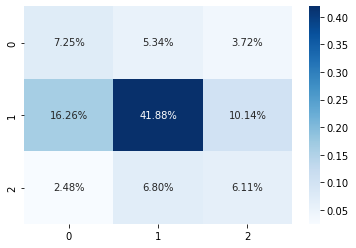

In [160]:
pred = xgbc4.predict(X_validation)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.22      0.33      0.26      7117
           1       0.62      0.48      0.54     19330
           2       0.36      0.46      0.41      4344

    accuracy                           0.44     30791
   macro avg       0.40      0.42      0.40     30791
weighted avg       0.49      0.44      0.46     30791

--------------------
The accuracy of the model is: 0.4388620051313696
--------------------
The f1-macro score for the model is: 0.4027619881653594
--------------------


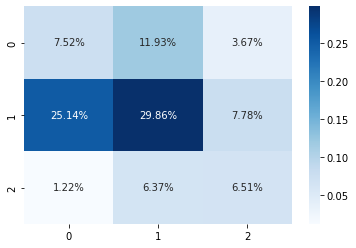

In [161]:
pred = xgbc4.predict(X_test)
score_pure_classification(pred_test, pred)

<b> Undersampled data standard scaled

In [162]:
xgbc5 = XGBClassifier(tree_method = 'gpu_hist', n_estimators = 500)
xgbc5.fit(X_train_under_st, pred_train_under)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

              precision    recall  f1-score   support

           0       0.29      0.46      0.36      5552
           1       0.78      0.63      0.69     23230
           2       0.31      0.39      0.35      5240

    accuracy                           0.56     34022
   macro avg       0.46      0.49      0.47     34022
weighted avg       0.63      0.56      0.59     34022

--------------------
The accuracy of the model is: 0.563811651284463
--------------------
The f1-macro score for the model is: 0.4664128229948317
--------------------


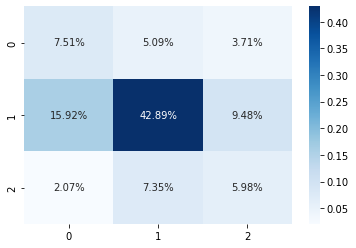

In [163]:
pred = xgbc5.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.23      0.33      0.27      7117
           1       0.64      0.50      0.56     19330
           2       0.36      0.47      0.41      4344

    accuracy                           0.46     30791
   macro avg       0.41      0.43      0.41     30791
weighted avg       0.50      0.46      0.47     30791

--------------------
The accuracy of the model is: 0.4563995972849209
--------------------
The f1-macro score for the model is: 0.4140037241595888
--------------------


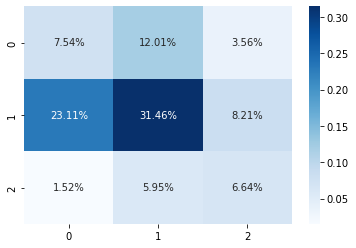

In [164]:
pred = xgbc5.predict(X_test_st)
score_pure_classification(pred_test, pred)

<b> Undersampled data minmax scaled

In [165]:
xgbc6 = XGBClassifier(tree_method = 'gpu_hist', n_estimators = 500)
xgbc6.fit(X_train_under_mm, pred_train_under)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

              precision    recall  f1-score   support

           0       0.30      0.46      0.36      5552
           1       0.78      0.63      0.70     23230
           2       0.31      0.39      0.34      5240

    accuracy                           0.57     34022
   macro avg       0.46      0.49      0.47     34022
weighted avg       0.63      0.57      0.59     34022

--------------------
The accuracy of the model is: 0.5660748927164776
--------------------
The f1-macro score for the model is: 0.4674079174278658
--------------------


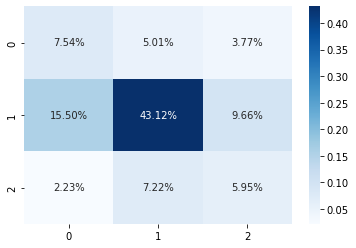

In [167]:
pred = xgbc6.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.22      0.32      0.26      7117
           1       0.63      0.49      0.55     19330
           2       0.36      0.48      0.41      4344

    accuracy                           0.45     30791
   macro avg       0.41      0.43      0.41     30791
weighted avg       0.50      0.45      0.46     30791

--------------------
The accuracy of the model is: 0.4469812607580137
--------------------
The f1-macro score for the model is: 0.4079918776201789
--------------------


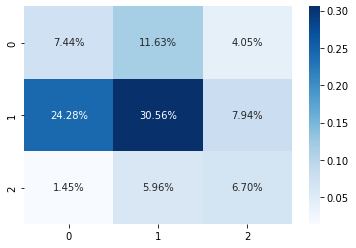

In [168]:
pred = xgbc6.predict(X_test_mm)
score_pure_classification(pred_test, pred)

### 5.1.3 LGMB Model

<b> Non-changed data

In [169]:
lgbmc1 = lgb.LGBMClassifier(objective="multiclass",device='gpu',n_estimators=16,learning_rate=0.07,
                           num_leaves=2591,max_depth=10,min_data_in_leaf=6140,
                           lambda_l1=16,lambda_l2=17,
                           min_gain_to_split=6.09,bagging_fraction=0.9,bagging_freq=1,feature_fraction=0.2)
lgbmc1.fit(X_train, pred_train)

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] min_gain_to_split is set=6.09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.09
[LightGBM] [Warning] min_data_in_leaf is set=6140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6140
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=17, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17


LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, device='gpu',
               feature_fraction=0.2, lambda_l1=16, lambda_l2=17,
               learning_rate=0.07, max_depth=10, min_data_in_leaf=6140,
               min_gain_to_split=6.09, n_estimators=16, num_leaves=2591,
               objective='multiclass')

              precision    recall  f1-score   support

           0       0.58      0.34      0.43      5552
           1       0.78      0.84      0.81     23230
           2       0.37      0.41      0.39      5240

    accuracy                           0.69     34022
   macro avg       0.58      0.53      0.54     34022
weighted avg       0.69      0.69      0.68     34022

--------------------
The accuracy of the model is: 0.6926988419258127
--------------------
The f1-macro score for the model is: 0.5435406096044925
--------------------


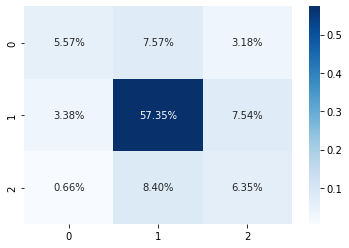

In [170]:
pred = lgbmc1.predict(X_validation)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.26      0.13      0.17      7117
           1       0.69      0.81      0.75     19330
           2       0.52      0.58      0.55      4344

    accuracy                           0.62     30791
   macro avg       0.49      0.50      0.49     30791
weighted avg       0.57      0.62      0.59     30791

--------------------
The accuracy of the model is: 0.6187847098178039
--------------------
The f1-macro score for the model is: 0.4898067961189638
--------------------


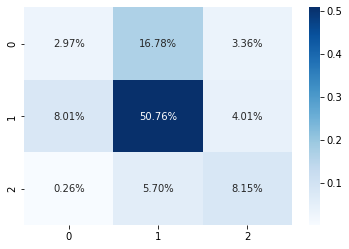

In [171]:
pred = lgbmc1.predict(X_test)
score_pure_classification(pred_test, pred)

<b> Non-changed data standard scaled

In [172]:
lgbmc2 = lgb.LGBMClassifier(objective="multiclass",device='gpu',n_estimators=16,learning_rate=0.07,
                           num_leaves=2591,max_depth=10,min_data_in_leaf=6140,
                           lambda_l1=16,lambda_l2=17,
                           min_gain_to_split=6.09,bagging_fraction=0.9,bagging_freq=1,feature_fraction=0.2)
lgbmc2.fit(X_train_st, pred_train)

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] min_gain_to_split is set=6.09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.09
[LightGBM] [Warning] min_data_in_leaf is set=6140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6140
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=17, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17


LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, device='gpu',
               feature_fraction=0.2, lambda_l1=16, lambda_l2=17,
               learning_rate=0.07, max_depth=10, min_data_in_leaf=6140,
               min_gain_to_split=6.09, n_estimators=16, num_leaves=2591,
               objective='multiclass')

              precision    recall  f1-score   support

           0       0.57      0.32      0.41      5552
           1       0.78      0.84      0.81     23230
           2       0.38      0.43      0.41      5240

    accuracy                           0.69     34022
   macro avg       0.58      0.53      0.54     34022
weighted avg       0.69      0.69      0.68     34022

--------------------
The accuracy of the model is: 0.6934042678267004
--------------------
The f1-macro score for the model is: 0.542719277666135
--------------------


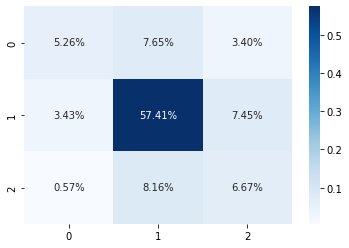

In [173]:
pred = lgbmc2.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.26      0.13      0.17      7117
           1       0.69      0.81      0.74     19330
           2       0.52      0.58      0.55      4344

    accuracy                           0.62     30791
   macro avg       0.49      0.50      0.49     30791
weighted avg       0.57      0.62      0.58     30791

--------------------
The accuracy of the model is: 0.6171283816699685
--------------------
The f1-macro score for the model is: 0.48814620636516604
--------------------


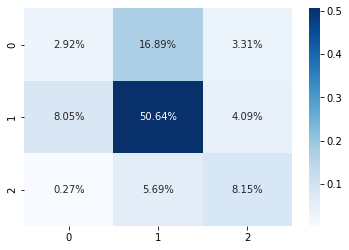

In [174]:
pred = lgbmc2.predict(X_test_st)
score_pure_classification(pred_test, pred)

<b> Non-changed data minmax scaled

In [175]:
lgbmc3 = lgb.LGBMClassifier(objective="multiclass",device='gpu',n_estimators=16,learning_rate=0.07,
                           num_leaves=2591,max_depth=10,min_data_in_leaf=6140,
                           lambda_l1=16,lambda_l2=17,
                           min_gain_to_split=6.09,bagging_fraction=0.9,bagging_freq=1,feature_fraction=0.2)
lgbmc3.fit(X_train_mm, pred_train)

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] min_gain_to_split is set=6.09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.09
[LightGBM] [Warning] min_data_in_leaf is set=6140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6140
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=17, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17


LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, device='gpu',
               feature_fraction=0.2, lambda_l1=16, lambda_l2=17,
               learning_rate=0.07, max_depth=10, min_data_in_leaf=6140,
               min_gain_to_split=6.09, n_estimators=16, num_leaves=2591,
               objective='multiclass')

              precision    recall  f1-score   support

           0       0.59      0.33      0.42      5552
           1       0.79      0.84      0.81     23230
           2       0.37      0.43      0.40      5240

    accuracy                           0.69     34022
   macro avg       0.58      0.53      0.54     34022
weighted avg       0.69      0.69      0.69     34022

--------------------
The accuracy of the model is: 0.6944036211862912
--------------------
The f1-macro score for the model is: 0.5448892109610176
--------------------


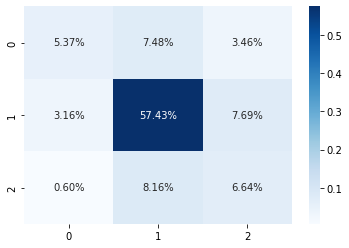

In [176]:
pred = lgbmc3.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.26      0.13      0.17      7117
           1       0.69      0.81      0.74     19330
           2       0.52      0.58      0.55      4344

    accuracy                           0.62     30791
   macro avg       0.49      0.50      0.49     30791
weighted avg       0.57      0.62      0.58     30791

--------------------
The accuracy of the model is: 0.6169659965574357
--------------------
The f1-macro score for the model is: 0.48851283810210155
--------------------


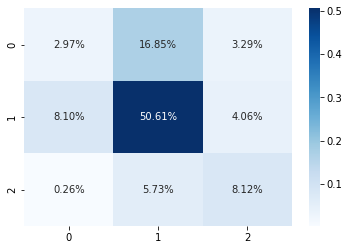

In [177]:
pred = lgbmc3.predict(X_test_mm)
score_pure_classification(pred_test,pred)

<b> Undersampled data

In [178]:
lgbmc4 = lgb.LGBMClassifier(objective="multiclass",device='gpu',n_estimators=16,learning_rate=0.07,
                           num_leaves=2591,max_depth=10,min_data_in_leaf=6140,
                           lambda_l1=16,lambda_l2=17,
                           min_gain_to_split=6.09,bagging_fraction=0.9,bagging_freq=1,feature_fraction=0.2)
lgbmc4.fit(X_train_under, pred_train_under)

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] min_gain_to_split is set=6.09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.09
[LightGBM] [Warning] min_data_in_leaf is set=6140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6140
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=17, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17


LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, device='gpu',
               feature_fraction=0.2, lambda_l1=16, lambda_l2=17,
               learning_rate=0.07, max_depth=10, min_data_in_leaf=6140,
               min_gain_to_split=6.09, n_estimators=16, num_leaves=2591,
               objective='multiclass')

              precision    recall  f1-score   support

           0       0.26      0.62      0.37      5552
           1       0.83      0.40      0.54     23230
           2       0.34      0.60      0.43      5240

    accuracy                           0.47     34022
   macro avg       0.48      0.54      0.45     34022
weighted avg       0.66      0.47      0.50     34022

--------------------
The accuracy of the model is: 0.4701369701957557
--------------------
The f1-macro score for the model is: 0.44661866847965204
--------------------


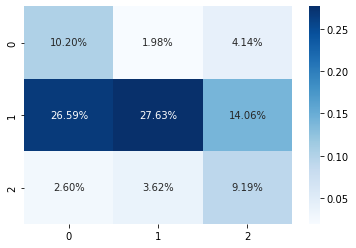

In [179]:
pred = lgbmc4.predict(X_validation)
score_pure_classification(pred_validation,pred)

              precision    recall  f1-score   support

           0       0.28      0.41      0.33      7117
           1       0.73      0.50      0.59     19330
           2       0.41      0.68      0.52      4344

    accuracy                           0.50     30791
   macro avg       0.47      0.53      0.48     30791
weighted avg       0.58      0.50      0.52     30791

--------------------
The accuracy of the model is: 0.5030366016043649
--------------------
The f1-macro score for the model is: 0.4799437656640027
--------------------


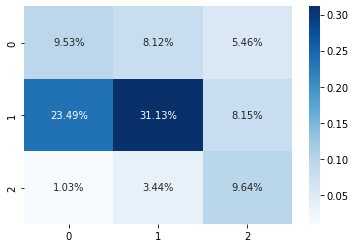

In [180]:
pred = lgbmc4.predict(X_test)
score_pure_classification(pred_test,pred)

<b> Undersampled data standard scaled

In [181]:
lgbmc5 = lgb.LGBMClassifier(objective="multiclass",device='gpu',n_estimators=16,learning_rate=0.07,
                           num_leaves=2591,max_depth=10,min_data_in_leaf=6140,
                           lambda_l1=16,lambda_l2=17,
                           min_gain_to_split=6.09,bagging_fraction=0.9,bagging_freq=1,feature_fraction=0.2)
lgbmc5.fit(X_train_under_st, pred_train_under)

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] min_gain_to_split is set=6.09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.09
[LightGBM] [Warning] min_data_in_leaf is set=6140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6140
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=17, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17


LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, device='gpu',
               feature_fraction=0.2, lambda_l1=16, lambda_l2=17,
               learning_rate=0.07, max_depth=10, min_data_in_leaf=6140,
               min_gain_to_split=6.09, n_estimators=16, num_leaves=2591,
               objective='multiclass')

              precision    recall  f1-score   support

           0       0.26      0.62      0.36      5552
           1       0.83      0.40      0.54     23230
           2       0.33      0.60      0.43      5240

    accuracy                           0.47     34022
   macro avg       0.47      0.54      0.44     34022
weighted avg       0.66      0.47      0.49     34022

--------------------
The accuracy of the model is: 0.46628652048674385
--------------------
The f1-macro score for the model is: 0.4435089943437464
--------------------


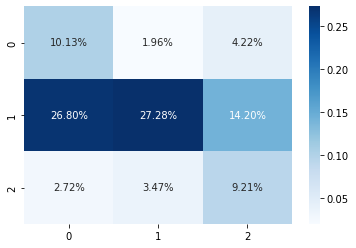

In [182]:
pred = lgbmc5.predict(X_validation_st)
score_pure_classification(pred_validation,pred)

              precision    recall  f1-score   support

           0       0.27      0.40      0.33      7117
           1       0.72      0.49      0.59     19330
           2       0.40      0.67      0.50      4344

    accuracy                           0.50     30791
   macro avg       0.47      0.52      0.47     30791
weighted avg       0.57      0.50      0.51     30791

--------------------
The accuracy of the model is: 0.49602156474294434
--------------------
The f1-macro score for the model is: 0.4710087905155949
--------------------


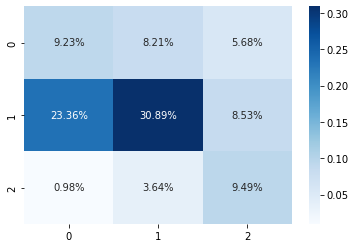

In [183]:
pred = lgbmc5.predict(X_test_st)
score_pure_classification(pred_test,pred)

<b> Undersampled data minmax scaled

In [184]:
lgbmc6 = lgb.LGBMClassifier(objective="multiclass",device='gpu',n_estimators=16,learning_rate=0.07,
                           num_leaves=2591,max_depth=10,min_data_in_leaf=6140,
                           lambda_l1=16,lambda_l2=17,
                           min_gain_to_split=6.09,bagging_fraction=0.9,bagging_freq=1,feature_fraction=0.2)
lgbmc6.fit(X_train_under_mm, pred_train_under)

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] min_gain_to_split is set=6.09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.09
[LightGBM] [Warning] min_data_in_leaf is set=6140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6140
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=17, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17


LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, device='gpu',
               feature_fraction=0.2, lambda_l1=16, lambda_l2=17,
               learning_rate=0.07, max_depth=10, min_data_in_leaf=6140,
               min_gain_to_split=6.09, n_estimators=16, num_leaves=2591,
               objective='multiclass')

              precision    recall  f1-score   support

           0       0.26      0.63      0.36      5552
           1       0.83      0.40      0.54     23230
           2       0.33      0.59      0.43      5240

    accuracy                           0.47     34022
   macro avg       0.47      0.54      0.44     34022
weighted avg       0.66      0.47      0.49     34022

--------------------
The accuracy of the model is: 0.46534595261889367
--------------------
The f1-macro score for the model is: 0.4430866700481777
--------------------


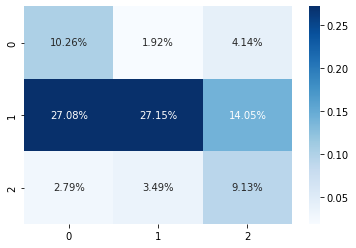

In [185]:
pred = lgbmc6.predict(X_validation_mm)
score_pure_classification(pred_validation,pred)

              precision    recall  f1-score   support

           0       0.28      0.41      0.33      7117
           1       0.73      0.49      0.59     19330
           2       0.41      0.68      0.51      4344

    accuracy                           0.50     30791
   macro avg       0.47      0.53      0.48     30791
weighted avg       0.58      0.50      0.52     30791

--------------------
The accuracy of the model is: 0.49855477249845737
--------------------
The f1-macro score for the model is: 0.47563505539558365
--------------------


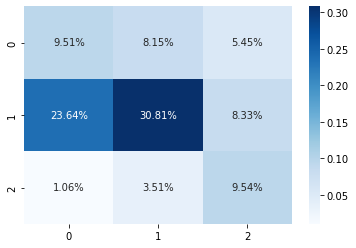

In [186]:
pred = lgbmc6.predict(X_test_mm)
score_pure_classification(pred_test,pred)

### 5.1.4 K-Nearest Neighbors Model

<b> Non-changed data

In [188]:
knnc1 = knnCMC(n_neighbors = 370)
knnc1.fit(X_train, pred_train)

KNeighborsClassifier()

              precision    recall  f1-score   support

           0       0.38      0.23      0.28      5552
           1       0.73      0.85      0.79     23230
           2       0.40      0.29      0.34      5240

    accuracy                           0.66     34022
   macro avg       0.50      0.46      0.47     34022
weighted avg       0.62      0.66      0.63     34022

--------------------
The accuracy of the model is: 0.6598965375345365
--------------------
The f1-macro score for the model is: 0.4689458637785187
--------------------


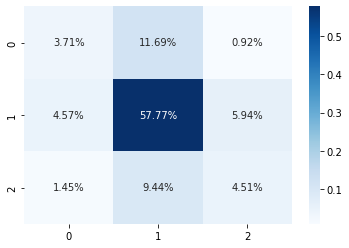

In [189]:
pred = knnc1.predict(X_validation)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.50      0.11      0.18      7117
           1       0.69      0.83      0.76     19330
           2       0.30      0.41      0.35      4344

    accuracy                           0.61     30791
   macro avg       0.50      0.45      0.43     30791
weighted avg       0.59      0.61      0.57     30791

--------------------
The accuracy of the model is: 0.6053716995225877
--------------------
The f1-macro score for the model is: 0.4279277850631893
--------------------


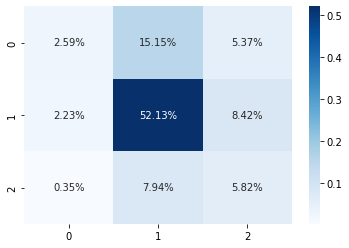

In [190]:
pred = knnc1.predict(X_test)
score_pure_classification(pred_test, pred)

<b> Non-changed data standard scaled

In [191]:
knnc2 = knnCMC(n_neighbors = 370)
knnc2.fit(X_train_st, pred_train)

KNeighborsClassifier()

              precision    recall  f1-score   support

           0       0.34      0.24      0.28      5552
           1       0.75      0.80      0.77     23230
           2       0.36      0.39      0.37      5240

    accuracy                           0.64     34022
   macro avg       0.48      0.47      0.48     34022
weighted avg       0.62      0.64      0.63     34022

--------------------
The accuracy of the model is: 0.6413791076362354
--------------------
The f1-macro score for the model is: 0.4750677419052634
--------------------


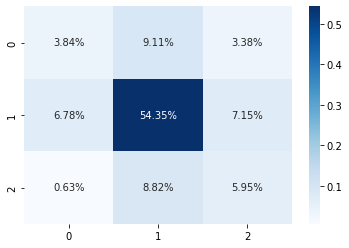

In [192]:
pred = knnc2.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.22      0.12      0.16      7117
           1       0.68      0.75      0.71     19330
           2       0.41      0.50      0.45      4344

    accuracy                           0.57     30791
   macro avg       0.43      0.46      0.44     30791
weighted avg       0.53      0.57      0.55     30791

--------------------
The accuracy of the model is: 0.5709785326881232
--------------------
The f1-macro score for the model is: 0.4404693869828829
--------------------


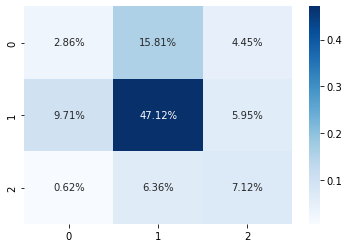

In [193]:
pred = knnc2.predict(X_test_st)
score_pure_classification(pred_test, pred)

<b> Non-changed data minmax scaled

In [195]:
knnc3 = knnCMC(n_neighbors = 370)
knnc3.fit(X_train_mm, pred_train)

KNeighborsClassifier()

              precision    recall  f1-score   support

           0       0.31      0.19      0.23      5552
           1       0.74      0.81      0.77     23230
           2       0.36      0.39      0.37      5240

    accuracy                           0.64     34022
   macro avg       0.47      0.46      0.46     34022
weighted avg       0.61      0.64      0.62     34022

--------------------
The accuracy of the model is: 0.6397037211216272
--------------------
The f1-macro score for the model is: 0.46051277040701993
--------------------


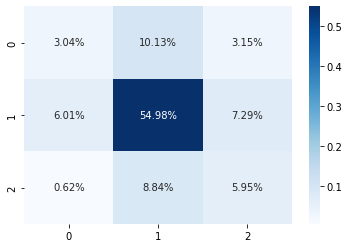

In [196]:
pred = knnc3.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.23      0.10      0.14      7117
           1       0.67      0.78      0.72     19330
           2       0.32      0.39      0.35      4344

    accuracy                           0.57     30791
   macro avg       0.41      0.42      0.41     30791
weighted avg       0.52      0.57      0.53     30791

--------------------
The accuracy of the model is: 0.5660420252671235
--------------------
The f1-macro score for the model is: 0.4054496278999437
--------------------


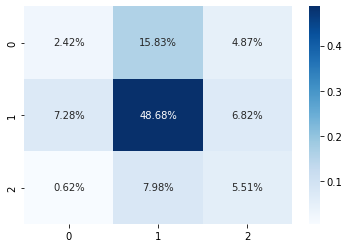

In [197]:
pred = knnc3.predict(X_test_mm)
score_pure_classification(pred_test, pred)

<b> Undersampled data

In [199]:
# Check if 320 or 370 is better because data is undersampled
knnc4 = knnCMC(n_neighbors = 370)
knnc4.fit(X_train_under, pred_train_under)

KNeighborsClassifier()

              precision    recall  f1-score   support

           0       0.26      0.59      0.36      5552
           1       0.78      0.54      0.63     23230
           2       0.33      0.34      0.33      5240

    accuracy                           0.51     34022
   macro avg       0.45      0.49      0.44     34022
weighted avg       0.62      0.51      0.54     34022

--------------------
The accuracy of the model is: 0.5142848744929751
--------------------
The f1-macro score for the model is: 0.44272954742016446
--------------------


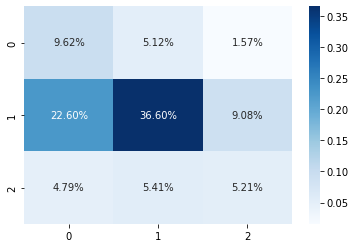

In [200]:
pred = knnc4.predict(X_validation)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.31      0.27      0.28      7117
           1       0.71      0.61      0.65     19330
           2       0.28      0.51      0.36      4344

    accuracy                           0.51     30791
   macro avg       0.43      0.46      0.43     30791
weighted avg       0.55      0.51      0.53     30791

--------------------
The accuracy of the model is: 0.5144360365041732
--------------------
The f1-macro score for the model is: 0.43154539257800034
--------------------


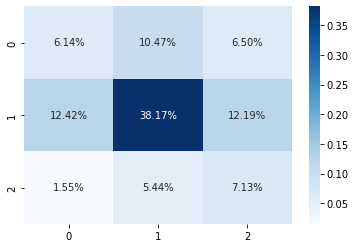

In [201]:
pred = knnc4.predict(X_test)
score_pure_classification(pred_test, pred)

<b> Undersampled data standard scaled

In [203]:
# Check if 320 or 370 is better because data is undersampled
knnc5 = knnCMC(n_neighbors = 370)
knnc5.fit(X_train_under_st, pred_train_under)

KNeighborsClassifier()

              precision    recall  f1-score   support

           0       0.23      0.51      0.31      5552
           1       0.77      0.46      0.58     23230
           2       0.33      0.47      0.39      5240

    accuracy                           0.47     34022
   macro avg       0.44      0.48      0.43     34022
weighted avg       0.61      0.47      0.51     34022

--------------------
The accuracy of the model is: 0.4726353535947328
--------------------
The f1-macro score for the model is: 0.4262845285137691
--------------------


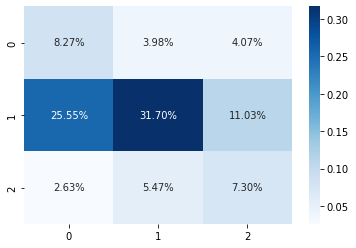

In [204]:
pred = knnc5.predict(X_validation_st)
score_pure_classification(pred_validation,pred)

              precision    recall  f1-score   support

           0       0.19      0.24      0.21      7117
           1       0.66      0.50      0.57     19330
           2       0.37      0.60      0.46      4344

    accuracy                           0.46     30791
   macro avg       0.41      0.45      0.41     30791
weighted avg       0.51      0.46      0.47     30791

--------------------
The accuracy of the model is: 0.4550355623396447
--------------------
The f1-macro score for the model is: 0.412792066071076
--------------------


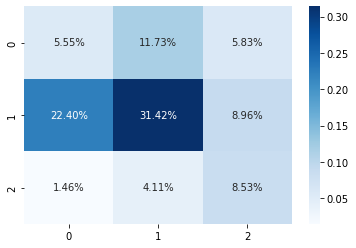

In [205]:
pred = knnc5.predict(X_test_st)
score_pure_classification(pred_test, pred)

<b> Undersampled data minmax scaled

In [207]:
# Check if 320 or 370 is better because data is undersampled
knnc6 = knnCMC(n_neighbors = 370)
knnc6.fit(X_train_under_mm, pred_train_under)

KNeighborsClassifier()

              precision    recall  f1-score   support

           0       0.24      0.49      0.32      5552
           1       0.78      0.49      0.60     23230
           2       0.32      0.48      0.39      5240

    accuracy                           0.49     34022
   macro avg       0.45      0.49      0.44     34022
weighted avg       0.62      0.49      0.52     34022

--------------------
The accuracy of the model is: 0.49194638763153253
--------------------
The f1-macro score for the model is: 0.4379762944621623
--------------------


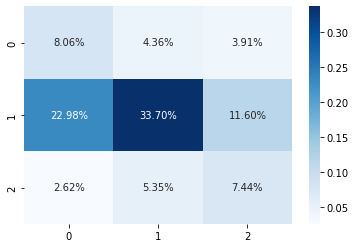

In [208]:
pred = knnc6.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.18      0.19      0.18      7117
           1       0.67      0.57      0.61     19330
           2       0.32      0.53      0.39      4344

    accuracy                           0.47     30791
   macro avg       0.39      0.43      0.40     30791
weighted avg       0.51      0.47      0.48     30791

--------------------
The accuracy of the model is: 0.4730927868533013
--------------------
The f1-macro score for the model is: 0.39751985733028844
--------------------


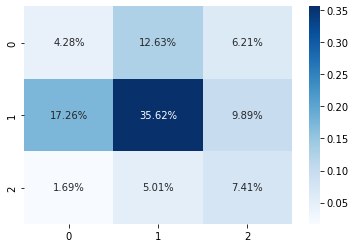

In [209]:
pred = knnc6.predict(X_test_mm)
score_pure_classification(pred_test, pred)

## 5.2 Regression + Classes

### 5.2.1 Random Forest Model

<b> Non-changed data

In [210]:
rfr1 = rfCMR(n_estimators=1000, n_bins = 256, split_criterion= 6)
rfr1.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:794: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return func(**kwargs)
/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


RandomForestRegressor()

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.3591029255386582
--------------------
Mean squared error: 3.19757810092261
--------------------
Root mean squared error: 1.788177312495215
--------------------
R2 score: 0.04645222802119631
--------------------
              precision    recall  f1-score   support

           0       0.31      0.26      0.28      5552
           1       0.70      0.86      0.77     23230
           2       0.65      0.09      0.16      5240

    accuracy                           0.64     34022
   macro avg       0.55      0.40      0.41     34022
weighted avg       0.63      0.64      0.60     34022

--------------------
The accuracy of the model is: 0.6442595967315267
--------------------
The f1-macro score for the model is: 0.4054862260880412
--------------------


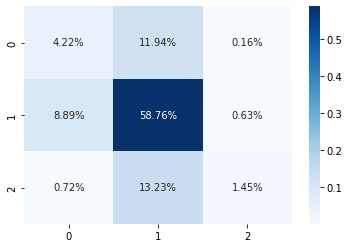

In [211]:
pred = rfr1.predict(X_validation)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.3434633723167497
--------------------
Mean squared error: 2.946246243616804
--------------------
Root mean squared error: 1.7164632951557117
--------------------
R2 score: 0.0008154826301808304
--------------------
              precision    recall  f1-score   support

           0       0.23      0.17      0.20      7117
           1       0.62      0.77      0.69     19330
           2       0.66      0.22      0.32      4344

    accuracy                           0.55     30791
   macro avg       0.50      0.39      0.40     30791
weighted avg       0.54      0.55      0.52     30791

--------------------
The accuracy of the model is: 0.5541879120522231
--------------------
The f1-macro score for the model is: 0.40363002075391874
--------------------


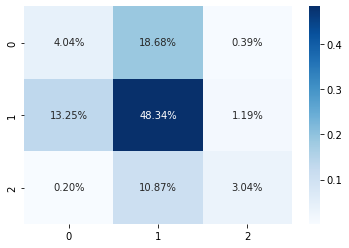

In [212]:
pred = rfr1.predict(X_test)
score_regression(y_test,pred)
score_classification(pred_test, transformData(pred))

<b> Non-changed data standard scaled

In [213]:
rfr2 = rfCMR(n_estimators=1000, n_bins = 256, split_criterion= 6)
rfr2.fit(X_train_st,y_train)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:794: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return func(**kwargs)
/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


RandomForestRegressor()

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.3591029255386582
--------------------
Mean squared error: 3.19757810092261
--------------------
Root mean squared error: 1.788177312495215
--------------------
R2 score: 0.04645222802119631
--------------------
              precision    recall  f1-score   support

           0       0.31      0.26      0.28      5552
           1       0.70      0.86      0.77     23230
           2       0.65      0.09      0.16      5240

    accuracy                           0.64     34022
   macro avg       0.55      0.40      0.41     34022
weighted avg       0.63      0.64      0.60     34022

--------------------
The accuracy of the model is: 0.6442595967315267
--------------------
The f1-macro score for the model is: 0.4054862260880412
--------------------


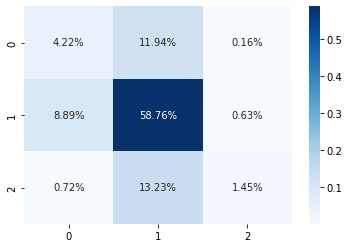

In [214]:
pred = rfr2.predict(X_validation_st)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.3434633723167497
--------------------
Mean squared error: 2.946246243616804
--------------------
Root mean squared error: 1.7164632951557117
--------------------
R2 score: 0.0008154826301808304
--------------------
              precision    recall  f1-score   support

           0       0.23      0.17      0.20      7117
           1       0.62      0.77      0.69     19330
           2       0.66      0.22      0.32      4344

    accuracy                           0.55     30791
   macro avg       0.50      0.39      0.40     30791
weighted avg       0.54      0.55      0.52     30791

--------------------
The accuracy of the model is: 0.5541879120522231
--------------------
The f1-macro score for the model is: 0.40363002075391874
--------------------


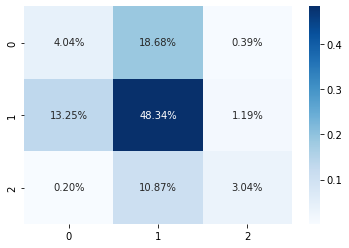

In [215]:
pred = rfr2.predict(X_test_st)
score_regression(y_test,pred)
score_classification(pred_test, transformData(pred))

<b> Non-changed data minmax scaled

In [ ]:
rfr3 = rfCMR(n_estimators=1000, n_bins = 256, split_criterion= 6)
rfr3.fit(X_train_mm,y_train)

In [ ]:
pred = rfr3.predict(X_validation_mm)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

In [ ]:
pred = rfr3.predict(X_test_mm)
score_regression(y_test,pred)
score_classification(pred_test, transformData(pred))

<b> Undersampled data

In [216]:
rfr4 = rfCMR(n_estimators=1000, n_bins = 256, split_criterion= 6)
rfr4.fit(X_train_under, y_train_under)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:794: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return func(**kwargs)
/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


RandomForestRegressor()

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.3856726834528557
--------------------
Mean squared error: 3.233169930191583
--------------------
Root mean squared error: 1.798101757463015
--------------------
R2 score: 0.035838410804257426
--------------------
              precision    recall  f1-score   support

           0       0.28      0.31      0.29      5552
           1       0.70      0.82      0.75     23230
           2       0.71      0.12      0.20      5240

    accuracy                           0.63     34022
   macro avg       0.56      0.41      0.42     34022
weighted avg       0.63      0.63      0.59     34022

--------------------
The accuracy of the model is: 0.62615366527541
--------------------
The f1-macro score for the model is: 0.41668823304877356
--------------------


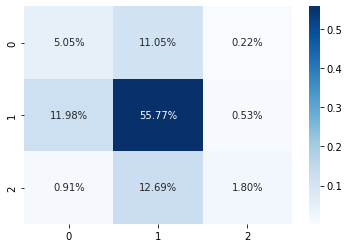

In [217]:
pred = rfr4.predict(X_validation)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.3625642229346915
--------------------
Mean squared error: 2.9654758794874927
--------------------
Root mean squared error: 1.7220557132356353
--------------------
R2 score: -0.00570602061425407
--------------------
              precision    recall  f1-score   support

           0       0.19      0.18      0.18      7117
           1       0.60      0.70      0.64     19330
           2       0.66      0.20      0.30      4344

    accuracy                           0.51     30791
   macro avg       0.48      0.36      0.38     30791
weighted avg       0.51      0.51      0.49     30791

--------------------
The accuracy of the model is: 0.5095320061056803
--------------------
The f1-macro score for the model is: 0.3778678304548058
--------------------


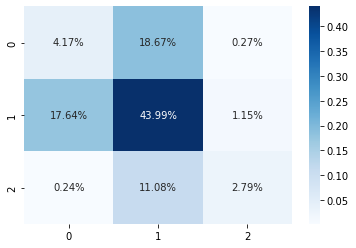

In [218]:
pred = rfr4.predict(X_test)
score_regression(y_test,pred)
score_classification(pred_test, transformData(pred))

<b> Undersampled data standard scaled

In [219]:
rfr5 = rfCMR(n_estimators=1000, n_bins = 256, split_criterion= 6)
rfr5.fit(X_train_under_st, y_train_under)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:794: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return func(**kwargs)
/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


RandomForestRegressor()

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.3856726834528557
--------------------
Mean squared error: 3.233169930191583
--------------------
Root mean squared error: 1.798101757463015
--------------------
R2 score: 0.035838410804257426
--------------------
              precision    recall  f1-score   support

           0       0.28      0.31      0.29      5552
           1       0.70      0.82      0.75     23230
           2       0.71      0.12      0.20      5240

    accuracy                           0.63     34022
   macro avg       0.56      0.41      0.42     34022
weighted avg       0.63      0.63      0.59     34022

--------------------
The accuracy of the model is: 0.62615366527541
--------------------
The f1-macro score for the model is: 0.41668823304877356
--------------------


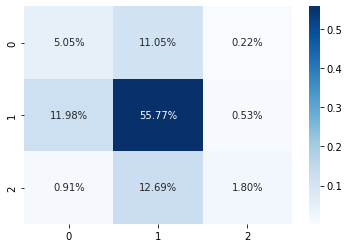

In [220]:
pred = rfr5.predict(X_validation_st)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.3625642229346915
--------------------
Mean squared error: 2.9654758794874927
--------------------
Root mean squared error: 1.7220557132356353
--------------------
R2 score: -0.00570602061425407
--------------------
              precision    recall  f1-score   support

           0       0.19      0.18      0.18      7117
           1       0.60      0.70      0.64     19330
           2       0.66      0.20      0.30      4344

    accuracy                           0.51     30791
   macro avg       0.48      0.36      0.38     30791
weighted avg       0.51      0.51      0.49     30791

--------------------
The accuracy of the model is: 0.5095320061056803
--------------------
The f1-macro score for the model is: 0.3778678304548058
--------------------


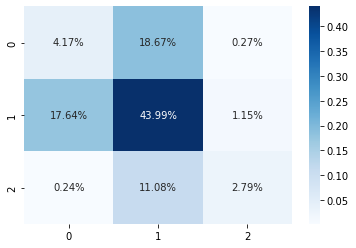

In [221]:
pred = rfr5.predict(X_test_st)
score_regression(y_test,pred)
score_classification(pred_test, transformData(pred))

<b> Undersampled data minmax scaled

In [ ]:
rfr6 = rfCMR(n_estimators=1000, n_bins = 256, split_criterion= 6)
rfr6.fit(X_train_under_st, y_train_under)

In [ ]:
pred = rfr6.predict(X_validation_mm)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

In [ ]:
pred = rfr6.predict(X_test_mm)
score_regression(y_test,pred)
score_classification(pred_test, transformData(pred))

### 5.2.2 XGBoost Model

<b> Non-changed data

In [222]:
xgbr1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators = 500)
xgbr1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Mean absolute error:  1.511920219062042
--------------------
Mean squared error: 3.8172130335003285
--------------------
Root mean squared error: 1.953768930426607
--------------------
R2 score: -0.13832871891775067
--------------------
              precision    recall  f1-score   support

           0       0.27      0.34      0.30      5552
           1       0.70      0.76      0.73     23230
           2       0.39      0.15      0.22      5240

    accuracy                           0.60     34022
   macro avg       0.46      0.42      0.42     34022
weighted avg       0.59      0.60      0.58     34022

--------------------
The accuracy of the model is: 0.5971430251014049
--------------------
The f1-macro score for the model is: 0.4172147919397245
--------------------


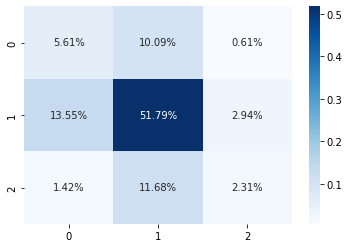

In [223]:
pred = xgbr1.predict(X_validation)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.4701108350059633
--------------------
Mean squared error: 3.495910591930468
--------------------
Root mean squared error: 1.8697354336724936
--------------------
R2 score: -0.18559667072430863
--------------------
              precision    recall  f1-score   support

           0       0.25      0.23      0.24      7117
           1       0.62      0.73      0.67     19330
           2       0.55      0.17      0.26      4344

    accuracy                           0.54     30791
   macro avg       0.47      0.38      0.39     30791
weighted avg       0.52      0.54      0.51     30791

--------------------
The accuracy of the model is: 0.5355461011334481
--------------------
The f1-macro score for the model is: 0.39019909537005604
--------------------


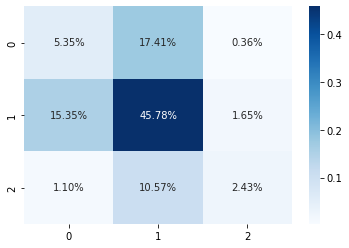

In [224]:
pred = xgbr1.predict(X_test)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Non-changed data standard scaled

In [225]:
xgbr2 = XGBRegressor(tree_method = 'gpu_hist', n_estimators = 500)
xgbr2.fit(X_train_st, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Mean absolute error:  1.525354816020608
--------------------
Mean squared error: 3.8454232107312567
--------------------
Root mean squared error: 1.9609750663206447
--------------------
R2 score: -0.14674125828243967
--------------------
              precision    recall  f1-score   support

           0       0.27      0.40      0.32      5552
           1       0.71      0.73      0.72     23230
           2       0.39      0.16      0.23      5240

    accuracy                           0.59     34022
   macro avg       0.46      0.43      0.42     34022
weighted avg       0.59      0.59      0.58     34022

--------------------
The accuracy of the model is: 0.5854447122450179
--------------------
The f1-macro score for the model is: 0.4229428088951612
--------------------


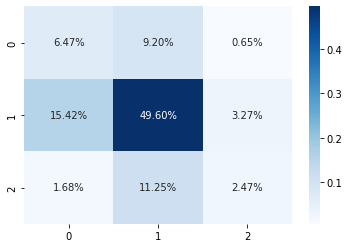

In [226]:
pred = xgbr2.predict(X_validation_st)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.4830804880789397
--------------------
Mean squared error: 3.4510402420373163
--------------------
Root mean squared error: 1.8576975647390284
--------------------
R2 score: -0.17037942301484166
--------------------
              precision    recall  f1-score   support

           0       0.23      0.24      0.23      7117
           1       0.60      0.69      0.64     19330
           2       0.50      0.16      0.25      4344

    accuracy                           0.51     30791
   macro avg       0.44      0.36      0.37     30791
weighted avg       0.50      0.51      0.49     30791

--------------------
The accuracy of the model is: 0.5088824656555487
--------------------
The f1-macro score for the model is: 0.37372782517794256
--------------------


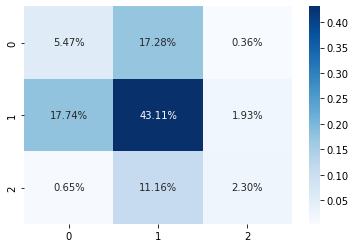

In [227]:
pred = xgbr2.predict(X_test_st)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Non-changed data minmax scaled

In [228]:
xgbr3 = XGBRegressor(tree_method = 'gpu_hist', n_estimators = 500)
xgbr3.fit(X_train_mm, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Mean absolute error:  1.4799942760723646
--------------------
Mean squared error: 3.6522901809670008
--------------------
Root mean squared error: 1.9110965912185078
--------------------
R2 score: -0.08914717788325088
--------------------
              precision    recall  f1-score   support

           0       0.26      0.40      0.32      5552
           1       0.71      0.73      0.72     23230
           2       0.47      0.15      0.22      5240

    accuracy                           0.59     34022
   macro avg       0.48      0.43      0.42     34022
weighted avg       0.60      0.59      0.58     34022

--------------------
The accuracy of the model is: 0.5852977485156663
--------------------
The f1-macro score for the model is: 0.42022494505601377
--------------------


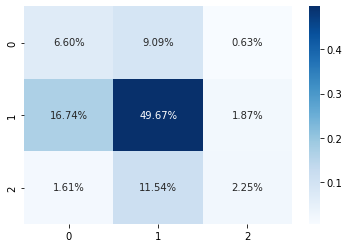

In [229]:
pred = xgbr3.predict(X_validation_mm)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.4623180893997656
--------------------
Mean squared error: 3.366692893539785
--------------------
Root mean squared error: 1.8348550061353035
--------------------
R2 score: -0.14177401880515483
--------------------
              precision    recall  f1-score   support

           0       0.24      0.25      0.24      7117
           1       0.61      0.69      0.65     19330
           2       0.52      0.13      0.21      4344

    accuracy                           0.51     30791
   macro avg       0.45      0.36      0.37     30791
weighted avg       0.51      0.51      0.49     30791

--------------------
The accuracy of the model is: 0.5120652138611932
--------------------
The f1-macro score for the model is: 0.3671321963304708
--------------------


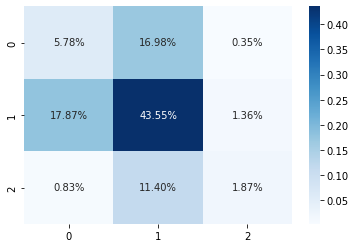

In [230]:
pred = xgbr3.predict(X_test_mm)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Undersample data

In [231]:
xgbr4 = XGBRegressor(tree_method = 'gpu_hist', n_estimators = 500)
xgbr4.fit(X_train_under, y_train_under)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Mean absolute error:  1.5209321311519692
--------------------
Mean squared error: 3.865234380914982
--------------------
Root mean squared error: 1.9660199340075324
--------------------
R2 score: -0.15264913499185728
--------------------
              precision    recall  f1-score   support

           0       0.26      0.43      0.32      5552
           1       0.70      0.69      0.70     23230
           2       0.43      0.15      0.23      5240

    accuracy                           0.57     34022
   macro avg       0.46      0.43      0.42     34022
weighted avg       0.59      0.57      0.56     34022

--------------------
The accuracy of the model is: 0.5673387807889013
--------------------
The f1-macro score for the model is: 0.41568232544713624
--------------------


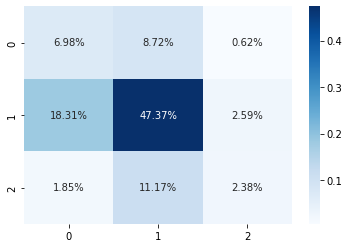

In [232]:
pred = xgbr4.predict(X_validation)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.4602159235565604
--------------------
Mean squared error: 3.327249804613627
--------------------
Root mean squared error: 1.8240750545450775
--------------------
R2 score: -0.12839736237066868
--------------------
              precision    recall  f1-score   support

           0       0.24      0.28      0.26      7117
           1       0.61      0.66      0.63     19330
           2       0.57      0.19      0.28      4344

    accuracy                           0.51     30791
   macro avg       0.47      0.38      0.39     30791
weighted avg       0.52      0.51      0.50     30791

--------------------
The accuracy of the model is: 0.5059920106524634
--------------------
The f1-macro score for the model is: 0.39153849449721684
--------------------


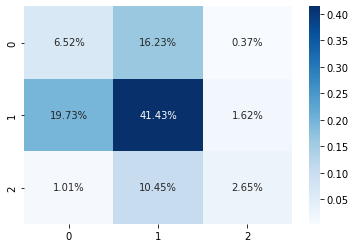

In [233]:
pred = xgbr4.predict(X_test)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Undersample data standard scaled

In [234]:
xgbr5 = XGBRegressor(tree_method = 'gpu_hist', n_estimators = 500)
xgbr5.fit(X_train_under_st, y_train_under)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Mean absolute error:  1.5249745911229793
--------------------
Mean squared error: 3.852924824061341
--------------------
Root mean squared error: 1.962886859719974
--------------------
R2 score: -0.14897830971680026
--------------------
              precision    recall  f1-score   support

           0       0.24      0.41      0.30      5552
           1       0.69      0.69      0.69     23230
           2       0.52      0.14      0.23      5240

    accuracy                           0.56     34022
   macro avg       0.48      0.41      0.41     34022
weighted avg       0.59      0.56      0.55     34022

--------------------
The accuracy of the model is: 0.5570219269884192
--------------------
The f1-macro score for the model is: 0.4051622603061937
--------------------


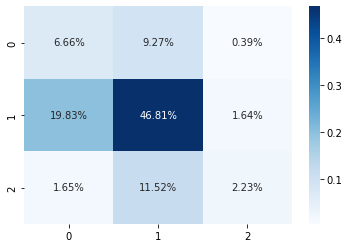

In [235]:
pred = xgbr5.predict(X_validation_st)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.4835315713509691
--------------------
Mean squared error: 3.397024266735072
--------------------
Root mean squared error: 1.8431018058520456
--------------------
R2 score: -0.1520605447711898
--------------------
              precision    recall  f1-score   support

           0       0.24      0.29      0.26      7117
           1       0.60      0.65      0.63     19330
           2       0.56      0.16      0.25      4344

    accuracy                           0.50     30791
   macro avg       0.46      0.37      0.38     30791
weighted avg       0.51      0.50      0.49     30791

--------------------
The accuracy of the model is: 0.4969309213731285
--------------------
The f1-macro score for the model is: 0.3770387572023997
--------------------


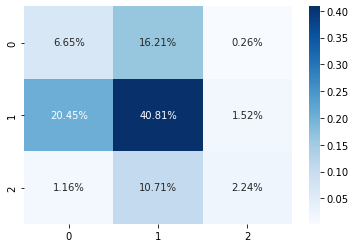

In [236]:
pred = xgbr5.predict(X_test_st)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Undersample data minmax scaled

In [237]:
xgbr6 = XGBRegressor(tree_method = 'gpu_hist', n_estimators = 500)
xgbr6.fit(X_train_under_mm, y_train_under)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Mean absolute error:  1.5671333019849094
--------------------
Mean squared error: 3.977998698329099
--------------------
Root mean squared error: 1.9944920903150003
--------------------
R2 score: -0.186276511786162
--------------------
              precision    recall  f1-score   support

           0       0.23      0.42      0.30      5552
           1       0.69      0.66      0.67     23230
           2       0.39      0.14      0.20      5240

    accuracy                           0.54     34022
   macro avg       0.44      0.40      0.39     34022
weighted avg       0.57      0.54      0.54     34022

--------------------
The accuracy of the model is: 0.5390335665157839
--------------------
The f1-macro score for the model is: 0.3913394769869392
--------------------


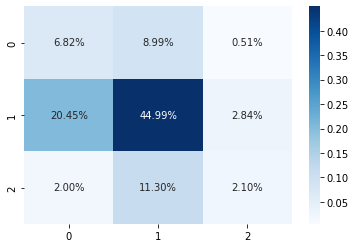

In [238]:
pred = xgbr6.predict(X_validation_mm)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.4896249865410076
--------------------
Mean squared error: 3.43787887619378
--------------------
Root mean squared error: 1.8541517942697627
--------------------
R2 score: -0.16591590167585202
--------------------
              precision    recall  f1-score   support

           0       0.21      0.26      0.23      7117
           1       0.59      0.64      0.61     19330
           2       0.55      0.18      0.27      4344

    accuracy                           0.48     30791
   macro avg       0.45      0.36      0.37     30791
weighted avg       0.50      0.48      0.48     30791

--------------------
The accuracy of the model is: 0.4842324055730571
--------------------
The f1-macro score for the model is: 0.3722280680457313
--------------------


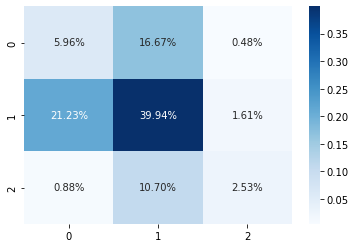

In [239]:
pred = xgbr6.predict(X_test_mm)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

### 5.2.3 LGBM Model

<b> Non-changed data

In [28]:
lgbmr1 = lgb.LGBMRegressor(n_estimators=18,learning_rate=0.18,num_leaves= 2420,max_depth= 3,min_data_in_leaf= 1600,lambda_l1= 0.27,lambda_l2= 62,
min_gain_to_split= 7.02,bagging_fraction= 0.5,bagging_freq=1,feature_fraction= 0.3,device='gpu',objective='regression',metric='l2')
lgbmr1.fit(X_train, y_train)

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.27, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27
[LightGBM] [Warning] min_gain_to_split is set=7.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.02
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=62, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62


LGBMRegressor(bagging_fraction=0.5, bagging_freq=1, device='gpu',
              feature_fraction=0.3, lambda_l1=0.27, lambda_l2=62,
              learning_rate=0.18, max_depth=3, metric='l2',
              min_data_in_leaf=1600, min_gain_to_split=7.02, n_estimators=18,
              num_leaves=2420, objective='regression')

Mean absolute error:  1.2721221215996525
--------------------
Mean squared error: 2.848971930871557
--------------------
Root mean squared error: 1.6878897863520463
--------------------
R2 score: 0.15040985665717344
--------------------
              precision    recall  f1-score   support

           0       0.59      0.37      0.45      5552
           1       0.73      0.94      0.82     23230
           2       0.74      0.07      0.13      5240

    accuracy                           0.71     34022
   macro avg       0.68      0.46      0.47     34022
weighted avg       0.71      0.71      0.65     34022

--------------------
The accuracy of the model is: 0.7119804832167421
--------------------
The f1-macro score for the model is: 0.4682704240057623
--------------------


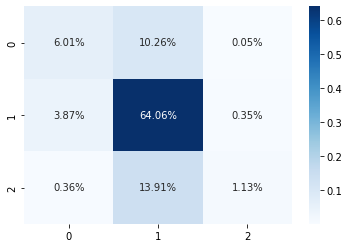

In [29]:
pred = lgbmr1.predict(X_validation)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.3056902226729958
--------------------
Mean squared error: 2.913557541435719
--------------------
Root mean squared error: 1.7069146262879462
--------------------
R2 score: 0.01190146880089471
--------------------
              precision    recall  f1-score   support

           0       0.21      0.07      0.10      7117
           1       0.63      0.89      0.73     19330
           2       0.59      0.15      0.24      4344

    accuracy                           0.59     30791
   macro avg       0.48      0.37      0.36     30791
weighted avg       0.53      0.59      0.52     30791

--------------------
The accuracy of the model is: 0.5941021727128057
--------------------
The f1-macro score for the model is: 0.35908496224398073
--------------------


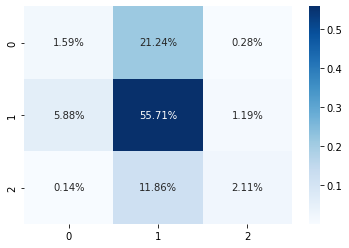

In [30]:
pred = lgbmr1.predict(X_test)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Non-changed data standard scaler

In [31]:
lgbmr2 = lgb.LGBMRegressor(n_estimators=18,learning_rate=0.18,num_leaves= 2420,max_depth= 3,min_data_in_leaf= 1600,lambda_l1= 0.27,lambda_l2= 62,
min_gain_to_split= 7.02,bagging_fraction= 0.5,bagging_freq=1,feature_fraction= 0.3,device='gpu',objective='regression',metric='l2')
lgbmr2.fit(X_train_st, y_train)

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.27, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27
[LightGBM] [Warning] min_gain_to_split is set=7.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.02
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=62, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62


LGBMRegressor(bagging_fraction=0.5, bagging_freq=1, device='gpu',
              feature_fraction=0.3, lambda_l1=0.27, lambda_l2=62,
              learning_rate=0.18, max_depth=3, metric='l2',
              min_data_in_leaf=1600, min_gain_to_split=7.02, n_estimators=18,
              num_leaves=2420, objective='regression')

Mean absolute error:  1.28450089950474
--------------------
Mean squared error: 2.873502282515336
--------------------
Root mean squared error: 1.6951407854556906
--------------------
R2 score: 0.14309467578667867
--------------------
              precision    recall  f1-score   support

           0       0.59      0.33      0.42      5552
           1       0.72      0.95      0.82     23230
           2       0.77      0.07      0.13      5240

    accuracy                           0.71     34022
   macro avg       0.70      0.45      0.46     34022
weighted avg       0.71      0.71      0.65     34022

--------------------
The accuracy of the model is: 0.7109223443654106
--------------------
The f1-macro score for the model is: 0.45868736685272715
--------------------


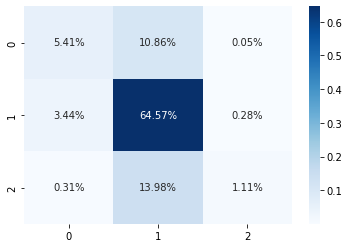

In [32]:
pred = lgbmr2.predict(X_validation_st)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.3006688850856478
--------------------
Mean squared error: 2.9027145856852297
--------------------
Root mean squared error: 1.7037354799631397
--------------------
R2 score: 0.015578728816715515
--------------------
              precision    recall  f1-score   support

           0       0.22      0.07      0.10      7117
           1       0.63      0.89      0.74     19330
           2       0.57      0.14      0.22      4344

    accuracy                           0.60     30791
   macro avg       0.47      0.37      0.35     30791
weighted avg       0.52      0.60      0.52     30791

--------------------
The accuracy of the model is: 0.5964080413107726
--------------------
The f1-macro score for the model is: 0.35456764114175393
--------------------


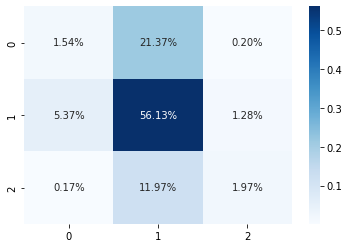

In [33]:
pred = lgbmr2.predict(X_test_st)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Non-changed data minmax scaler

In [34]:
lgbmr3 = lgb.LGBMRegressor(n_estimators=18,learning_rate=0.18,num_leaves= 2420,max_depth= 3,min_data_in_leaf= 1600,lambda_l1= 0.27,lambda_l2= 62,
min_gain_to_split= 7.02,bagging_fraction= 0.5,bagging_freq=1,feature_fraction= 0.3,device='gpu',objective='regression',metric='l2')
lgbmr3.fit(X_train_mm, y_train)

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.27, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27
[LightGBM] [Warning] min_gain_to_split is set=7.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.02
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=62, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62


LGBMRegressor(bagging_fraction=0.5, bagging_freq=1, device='gpu',
              feature_fraction=0.3, lambda_l1=0.27, lambda_l2=62,
              learning_rate=0.18, max_depth=3, metric='l2',
              min_data_in_leaf=1600, min_gain_to_split=7.02, n_estimators=18,
              num_leaves=2420, objective='regression')

Mean absolute error:  1.2739463617060491
--------------------
Mean squared error: 2.859288133660426
--------------------
Root mean squared error: 1.690942971735128
--------------------
R2 score: 0.14733346825503557
--------------------
              precision    recall  f1-score   support

           0       0.60      0.32      0.42      5552
           1       0.72      0.95      0.82     23230
           2       0.69      0.06      0.12      5240

    accuracy                           0.71     34022
   macro avg       0.67      0.44      0.45     34022
weighted avg       0.70      0.71      0.64     34022

--------------------
The accuracy of the model is: 0.7089824231379696
--------------------
The f1-macro score for the model is: 0.4508227411502232
--------------------


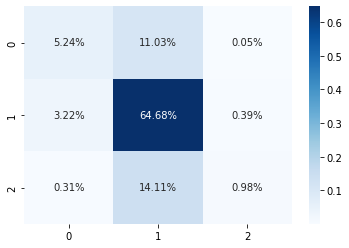

In [35]:
pred = lgbmr3.predict(X_validation_mm)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.2946459446589418
--------------------
Mean squared error: 2.887898322071631
--------------------
Root mean squared error: 1.6993817470102563
--------------------
R2 score: 0.0206034891333563
--------------------
              precision    recall  f1-score   support

           0       0.24      0.08      0.12      7117
           1       0.63      0.90      0.74     19330
           2       0.62      0.15      0.25      4344

    accuracy                           0.60     30791
   macro avg       0.50      0.38      0.37     30791
weighted avg       0.54      0.60      0.53     30791

--------------------
The accuracy of the model is: 0.6041050956448313
--------------------
The f1-macro score for the model is: 0.36832838610535706
--------------------


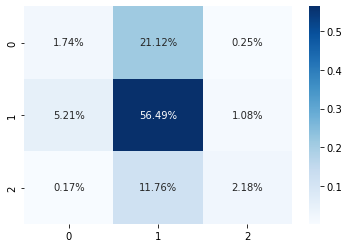

In [36]:
pred = lgbmr3.predict(X_test_mm)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Undersampled data

In [37]:
lgbmr4 = lgb.LGBMRegressor(n_estimators=18,learning_rate=0.18,num_leaves= 2420,max_depth= 3,min_data_in_leaf= 1600,lambda_l1= 0.27,lambda_l2= 62,
min_gain_to_split= 7.02,bagging_fraction= 0.5,bagging_freq=1,feature_fraction= 0.3,device='gpu',objective='regression',metric='l2')
lgbmr4.fit(X_train_under, y_train_under)

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.27, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27
[LightGBM] [Warning] min_gain_to_split is set=7.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.02
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=62, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62


LGBMRegressor(bagging_fraction=0.5, bagging_freq=1, device='gpu',
              feature_fraction=0.3, lambda_l1=0.27, lambda_l2=62,
              learning_rate=0.18, max_depth=3, metric='l2',
              min_data_in_leaf=1600, min_gain_to_split=7.02, n_estimators=18,
              num_leaves=2420, objective='regression')

Mean absolute error:  1.3296923059601902
--------------------
Mean squared error: 2.9670145355860655
--------------------
Root mean squared error: 1.7225024051031295
--------------------
R2 score: 0.115208445097713
--------------------
              precision    recall  f1-score   support

           0       0.41      0.45      0.43      5552
           1       0.73      0.85      0.78     23230
           2       0.72      0.11      0.18      5240

    accuracy                           0.67     34022
   macro avg       0.62      0.47      0.47     34022
weighted avg       0.67      0.67      0.63     34022

--------------------
The accuracy of the model is: 0.669155252483687
--------------------
The f1-macro score for the model is: 0.4650471962207663
--------------------


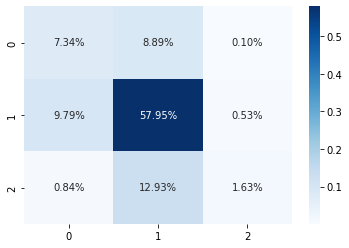

In [38]:
pred = lgbmr4.predict(X_validation)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.3503203007858324
--------------------
Mean squared error: 2.9458712641550635
--------------------
Root mean squared error: 1.7163540614206219
--------------------
R2 score: 0.000942652473269967
--------------------
              precision    recall  f1-score   support

           0       0.21      0.17      0.19      7117
           1       0.61      0.76      0.67     19330
           2       0.58      0.14      0.23      4344

    accuracy                           0.53     30791
   macro avg       0.47      0.36      0.36     30791
weighted avg       0.51      0.53      0.50     30791

--------------------
The accuracy of the model is: 0.5339222500081192
--------------------
The f1-macro score for the model is: 0.36355204334720886
--------------------


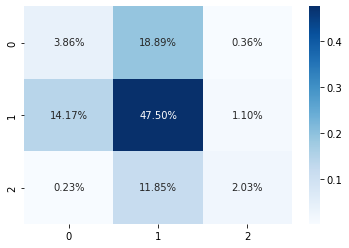

In [39]:
pred = lgbmr4.predict(X_test)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Undersampled data standard scaler

In [40]:
lgbmr5 = lgb.LGBMRegressor(n_estimators=18,learning_rate=0.18,num_leaves= 2420,max_depth= 3,min_data_in_leaf= 1600,lambda_l1= 0.27,lambda_l2= 62,
min_gain_to_split= 7.02,bagging_fraction= 0.5,bagging_freq=1,feature_fraction= 0.3,device='gpu',objective='regression',metric='l2')
lgbmr5.fit(X_train_under_st, y_train_under)

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.27, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27
[LightGBM] [Warning] min_gain_to_split is set=7.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.02
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=62, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62


LGBMRegressor(bagging_fraction=0.5, bagging_freq=1, device='gpu',
              feature_fraction=0.3, lambda_l1=0.27, lambda_l2=62,
              learning_rate=0.18, max_depth=3, metric='l2',
              min_data_in_leaf=1600, min_gain_to_split=7.02, n_estimators=18,
              num_leaves=2420, objective='regression')

Mean absolute error:  1.340204436224824
--------------------
Mean squared error: 2.989493660999439
--------------------
Root mean squared error: 1.7290152286777116
--------------------
R2 score: 0.10850495912257152
--------------------
              precision    recall  f1-score   support

           0       0.36      0.47      0.41      5552
           1       0.72      0.80      0.76     23230
           2       0.71      0.12      0.20      5240

    accuracy                           0.64     34022
   macro avg       0.60      0.46      0.46     34022
weighted avg       0.66      0.64      0.62     34022

--------------------
The accuracy of the model is: 0.6418199988242902
--------------------
The f1-macro score for the model is: 0.4564168685896362
--------------------


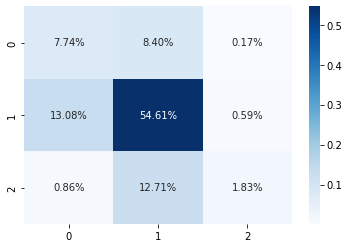

In [41]:
pred = lgbmr5.predict(X_validation_st)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.3507313347276977
--------------------
Mean squared error: 2.968715606394132
--------------------
Root mean squared error: 1.7229961132846852
--------------------
R2 score: -0.00680473562242212
--------------------
              precision    recall  f1-score   support

           0       0.19      0.17      0.18      7117
           1       0.60      0.72      0.65     19330
           2       0.60      0.16      0.25      4344

    accuracy                           0.51     30791
   macro avg       0.46      0.35      0.36     30791
weighted avg       0.51      0.51      0.49     30791

--------------------
The accuracy of the model is: 0.5127472313338313
--------------------
The f1-macro score for the model is: 0.361115042519811
--------------------


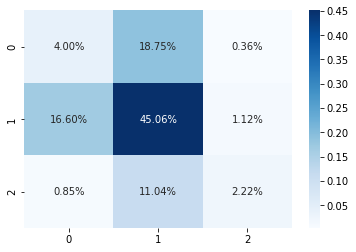

In [42]:
pred = lgbmr5.predict(X_test_st)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Undersampled data minmax scaler

In [43]:
lgbmr6 = lgb.LGBMRegressor(n_estimators=18,learning_rate=0.18,num_leaves= 2420,max_depth= 3,min_data_in_leaf= 1600,lambda_l1= 0.27,lambda_l2= 62,
min_gain_to_split= 7.02,bagging_fraction= 0.5,bagging_freq=1,feature_fraction= 0.3,device='gpu',objective='regression',metric='l2')
lgbmr6.fit(X_train_under_mm, y_train_under)

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.27, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27
[LightGBM] [Warning] min_gain_to_split is set=7.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.02
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=62, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62


LGBMRegressor(bagging_fraction=0.5, bagging_freq=1, device='gpu',
              feature_fraction=0.3, lambda_l1=0.27, lambda_l2=62,
              learning_rate=0.18, max_depth=3, metric='l2',
              min_data_in_leaf=1600, min_gain_to_split=7.02, n_estimators=18,
              num_leaves=2420, objective='regression')

Mean absolute error:  1.3455166838406953
--------------------
Mean squared error: 2.9942753274122476
--------------------
Root mean squared error: 1.7303974478171908
--------------------
R2 score: 0.10707902136268888
--------------------
              precision    recall  f1-score   support

           0       0.36      0.47      0.41      5552
           1       0.72      0.81      0.76     23230
           2       0.70      0.11      0.19      5240

    accuracy                           0.64     34022
   macro avg       0.59      0.46      0.45     34022
weighted avg       0.66      0.64      0.62     34022

--------------------
The accuracy of the model is: 0.6447298806654518
--------------------
The f1-macro score for the model is: 0.4539826905329043
--------------------


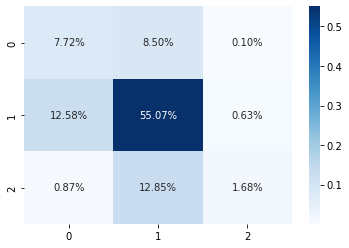

In [44]:
pred = lgbmr6.predict(X_validation_mm)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.3608850352273179
--------------------
Mean squared error: 3.015400170110578
--------------------
Root mean squared error: 1.7364907630363537
--------------------
R2 score: -0.02263725246201087
--------------------
              precision    recall  f1-score   support

           0       0.18      0.18      0.18      7117
           1       0.59      0.70      0.64     19330
           2       0.57      0.15      0.24      4344

    accuracy                           0.50     30791
   macro avg       0.45      0.34      0.35     30791
weighted avg       0.50      0.50      0.48     30791

--------------------
The accuracy of the model is: 0.501575135591569
--------------------
The f1-macro score for the model is: 0.35440670296789195
--------------------


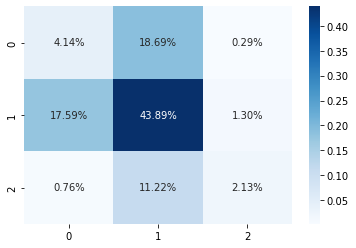

In [45]:
pred = lgbmr6.predict(X_test_mm)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

### 5.2.4 K-Nearest Neighbors Model

<b> Non-changed

In [46]:
knnr1 = knnCMR(n_neighbors = 370)
knnr1.fit(X_train, y_train)

KNeighborsRegressor()

Mean absolute error:  1.5654282523073306
--------------------
Mean squared error: 3.8597084239609663
--------------------
Root mean squared error: 1.9646140648893273
--------------------
R2 score: -0.15100124281370153
--------------------
              precision    recall  f1-score   support

           0       0.38      0.31      0.34      5552
           1       0.71      0.89      0.79     23230
           2       0.34      0.03      0.06      5240

    accuracy                           0.66     34022
   macro avg       0.48      0.41      0.40     34022
weighted avg       0.60      0.66      0.60     34022

--------------------
The accuracy of the model is: 0.6621303862206808
--------------------
The f1-macro score for the model is: 0.3974324503183579
--------------------


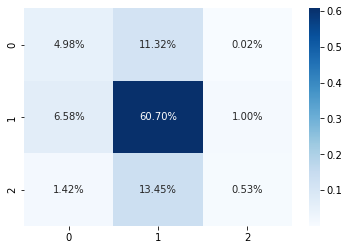

In [47]:
pred = knnr1.predict(X_validation)
score_regression(y_validation,pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.4412328277743496
--------------------
Mean squared error: 3.425708811016206
--------------------
Root mean squared error: 1.8508670430412353
--------------------
R2 score: -0.16178856821648524
--------------------
              precision    recall  f1-score   support

           0       0.39      0.09      0.15      7117
           1       0.65      0.91      0.76     19330
           2       0.42      0.18      0.25      4344

    accuracy                           0.62     30791
   macro avg       0.48      0.39      0.38     30791
weighted avg       0.55      0.62      0.54     30791

--------------------
The accuracy of the model is: 0.6179078302101263
--------------------
The f1-macro score for the model is: 0.38333034210192657
--------------------


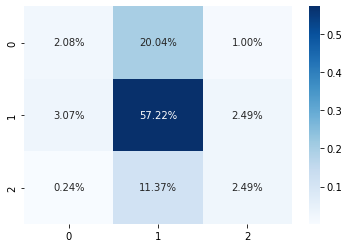

In [48]:
pred = knnr1.predict(X_test)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Non-changed standard scaler

In [49]:
knnr2 = knnCMR(n_neighbors = 370)
knnr2.fit(X_train_st, y_train)

KNeighborsRegressor()

Mean absolute error:  1.5082299688436893
--------------------
Mean squared error: 3.6181000529069425
--------------------
Root mean squared error: 1.9021303985024114
--------------------
R2 score: -0.07895136110994616
--------------------
              precision    recall  f1-score   support

           0       0.47      0.32      0.38      5552
           1       0.72      0.91      0.80     23230
           2       0.61      0.12      0.20      5240

    accuracy                           0.69     34022
   macro avg       0.60      0.45      0.46     34022
weighted avg       0.66      0.69      0.64     34022

--------------------
The accuracy of the model is: 0.690788313444242
--------------------
The f1-macro score for the model is: 0.46066298996974503
--------------------


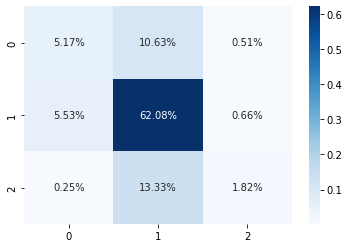

In [50]:
pred = knnr2.predict(X_validation_st)
score_regression(y_validation,pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.4446104381150335
--------------------
Mean squared error: 3.160241629047449
--------------------
Root mean squared error: 1.7777068456434117
--------------------
R2 score: -0.07175851771827668
--------------------
              precision    recall  f1-score   support

           0       0.15      0.05      0.08      7117
           1       0.63      0.88      0.73     19330
           2       0.66      0.19      0.30      4344

    accuracy                           0.59     30791
   macro avg       0.48      0.37      0.37     30791
weighted avg       0.52      0.59      0.52     30791

--------------------
The accuracy of the model is: 0.5902698840570296
--------------------
The f1-macro score for the model is: 0.36832957089019486
--------------------


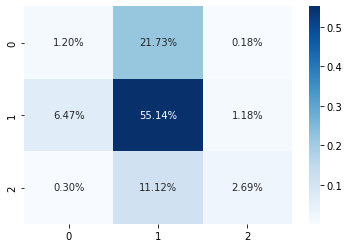

In [51]:
pred = knnr2.predict(X_test_st)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Non-changed data minmax scaler

In [52]:
knnr3 = knnCMR(n_neighbors = 370)
knnr3.fit(X_train_mm, y_train)

KNeighborsRegressor()

Mean absolute error:  1.520075245429428
--------------------
Mean squared error: 3.6322967491623066
--------------------
Root mean squared error: 1.9058585333550617
--------------------
R2 score: -0.08318494904947338
--------------------
              precision    recall  f1-score   support

           0       0.39      0.27      0.32      5552
           1       0.71      0.90      0.80     23230
           2       0.66      0.11      0.20      5240

    accuracy                           0.68     34022
   macro avg       0.59      0.43      0.44     34022
weighted avg       0.65      0.68      0.63     34022

--------------------
The accuracy of the model is: 0.6750338016577508
--------------------
The f1-macro score for the model is: 0.4373725930944658
--------------------


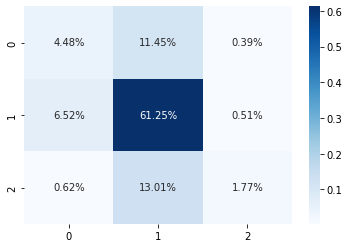

In [53]:
pred = knnr3.predict(X_validation_mm)
score_regression(y_validation,pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.4498392387385926
--------------------
Mean squared error: 3.2941443928420644
--------------------
Root mean squared error: 1.814977794035526
--------------------
R2 score: -0.11717005407796766
--------------------
              precision    recall  f1-score   support

           0       0.15      0.05      0.07      7117
           1       0.63      0.90      0.74     19330
           2       0.77      0.18      0.29      4344

    accuracy                           0.60     30791
   macro avg       0.52      0.37      0.37     30791
weighted avg       0.54      0.60      0.52     30791

--------------------
The accuracy of the model is: 0.5997856516514566
--------------------
The f1-macro score for the model is: 0.36715627810247525
--------------------


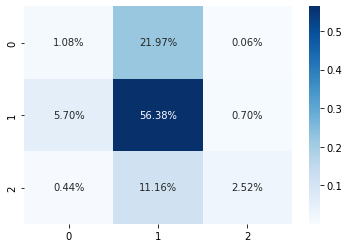

In [54]:
pred = knnr3.predict(X_test_mm)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Undersampled data

In [55]:
# Check if 320 or 370 is better because data is undersampled
knnr4 = knnCMR(n_neighbors = 370)
knnr4.fit(X_train_under, y_train_under)

KNeighborsRegressor()

Mean absolute error:  1.6526953147963084
--------------------
Mean squared error: 4.173652342601846
--------------------
Root mean squared error: 2.0429518698691473
--------------------
R2 score: -0.2446222630664765
--------------------
              precision    recall  f1-score   support

           0       0.30      0.41      0.34      5552
           1       0.71      0.78      0.75     23230
           2       0.37      0.06      0.10      5240

    accuracy                           0.61     34022
   macro avg       0.46      0.42      0.40     34022
weighted avg       0.59      0.61      0.58     34022

--------------------
The accuracy of the model is: 0.6106342954558814
--------------------
The f1-macro score for the model is: 0.39624520955407916
--------------------


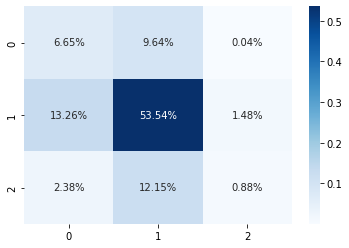

In [56]:
pred = knnr4.predict(X_validation)
score_regression(y_validation,pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.5044980676171609
--------------------
Mean squared error: 3.6472670585560714
--------------------
Root mean squared error: 1.9097819400539087
--------------------
R2 score: -0.23692742367266084
--------------------
              precision    recall  f1-score   support

           0       0.30      0.15      0.20      7117
           1       0.64      0.83      0.73     19330
           2       0.39      0.21      0.28      4344

    accuracy                           0.59     30791
   macro avg       0.45      0.40      0.40     30791
weighted avg       0.53      0.59      0.54     30791

--------------------
The accuracy of the model is: 0.5858530089961352
--------------------
The f1-macro score for the model is: 0.400161875846071
--------------------


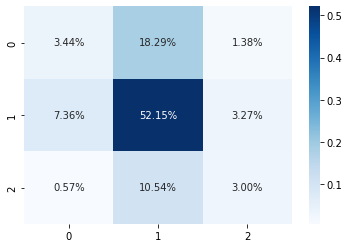

In [57]:
pred = knnr4.predict(X_test)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Undersampled data standard scaler

In [58]:
# Check if 320 or 370 is better because data is undersampled
knnr5 = knnCMR(n_neighbors = 370)
knnr5.fit(X_train_under_st, y_train_under)

KNeighborsRegressor()

Mean absolute error:  1.5903826935512315
--------------------
Mean squared error: 3.861677737934278
--------------------
Root mean squared error: 1.9651151971154968
--------------------
R2 score: -0.15158851070593404
--------------------
              precision    recall  f1-score   support

           0       0.32      0.40      0.36      5552
           1       0.71      0.80      0.75     23230
           2       0.58      0.13      0.21      5240

    accuracy                           0.63     34022
   macro avg       0.54      0.44      0.44     34022
weighted avg       0.63      0.63      0.61     34022

--------------------
The accuracy of the model is: 0.6301216859679031
--------------------
The f1-macro score for the model is: 0.440545318227668
--------------------


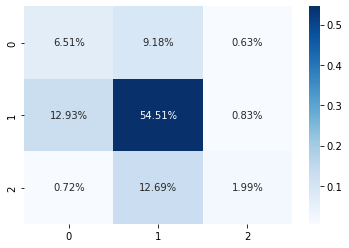

In [59]:
pred = knnr5.predict(X_validation_st)
score_regression(y_validation,pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.5352213309083824
--------------------
Mean squared error: 3.448572634860836
--------------------
Root mean squared error: 1.8570332885710035
--------------------
R2 score: -0.16954256326795814
--------------------
              precision    recall  f1-score   support

           0       0.12      0.10      0.11      7117
           1       0.60      0.74      0.66     19330
           2       0.65      0.20      0.31      4344

    accuracy                           0.52     30791
   macro avg       0.46      0.35      0.36     30791
weighted avg       0.50      0.52      0.48     30791

--------------------
The accuracy of the model is: 0.5152154850443311
--------------------
The f1-macro score for the model is: 0.359724531337032
--------------------


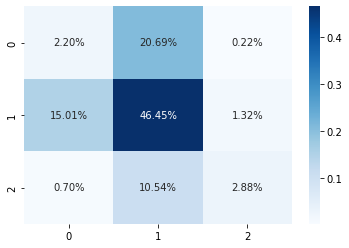

In [60]:
pred = knnr5.predict(X_test_st)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Undersampled data minmax scaler

In [61]:
# Check if 320 or 370 is better because data is undersampled
knnr6 = knnCMR(n_neighbors = 370)
knnr6.fit(X_train_under_mm, y_train_under)

KNeighborsRegressor()

Mean absolute error:  1.5937922520721886
--------------------
Mean squared error: 3.845864440656046
--------------------
Root mean squared error: 1.9610875657797757
--------------------
R2 score: -0.14687283718323085
--------------------
              precision    recall  f1-score   support

           0       0.29      0.38      0.33      5552
           1       0.71      0.79      0.75     23230
           2       0.64      0.13      0.22      5240

    accuracy                           0.62     34022
   macro avg       0.55      0.43      0.43     34022
weighted avg       0.63      0.62      0.60     34022

--------------------
The accuracy of the model is: 0.6201869378637352
--------------------
The f1-macro score for the model is: 0.4328471018529186
--------------------


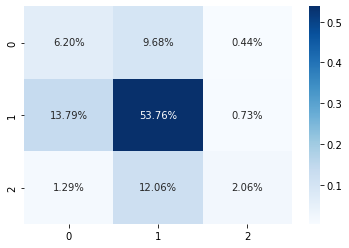

In [62]:
pred = knnr6.predict(X_validation_mm)
score_regression(y_validation,pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.509467052060667
--------------------
Mean squared error: 3.5130395245363903
--------------------
Root mean squared error: 1.8743104130683343
--------------------
R2 score: -0.19140574533780685
--------------------
              precision    recall  f1-score   support

           0       0.13      0.08      0.10      7117
           1       0.62      0.81      0.70     19330
           2       0.71      0.19      0.30      4344

    accuracy                           0.55     30791
   macro avg       0.49      0.36      0.37     30791
weighted avg       0.52      0.55      0.50     30791

--------------------
The accuracy of the model is: 0.5530187392419863
--------------------
The f1-macro score for the model is: 0.3665776857236387
--------------------


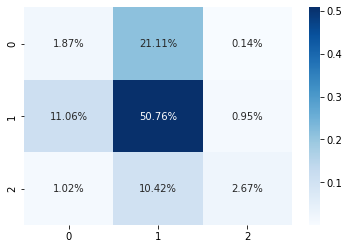

In [63]:
pred = knnr6.predict(X_test_mm)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

## 5.3 One Vs Rest

### 5.3.1 SVC rbf OvR

<b> Non-changed data

In [64]:
svc1 = SVC(kernel = 'rbf', multiclass_strategy= 'ovr')
svc1.fit(X_train, pred_train)

SVC()

              precision    recall  f1-score   support

           0       0.39      0.13      0.20      5552
           1       0.72      0.89      0.80     23230
           2       0.43      0.28      0.34      5240

    accuracy                           0.67     34022
   macro avg       0.51      0.43      0.45     34022
weighted avg       0.62      0.67      0.63     34022

--------------------
The accuracy of the model is: 0.6745635177238257
--------------------
The f1-macro score for the model is: 0.44516593768995527
--------------------


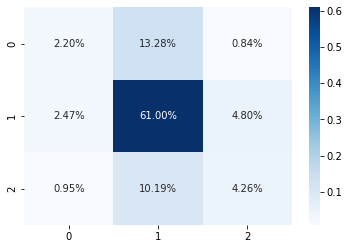

In [65]:
pred = svc1.predict(X_validation)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.49      0.09      0.15      7117
           1       0.69      0.85      0.76     19330
           2       0.31      0.39      0.34      4344

    accuracy                           0.61     30791
   macro avg       0.49      0.44      0.42     30791
weighted avg       0.59      0.61      0.56     30791

--------------------
The accuracy of the model is: 0.6112500405962782
--------------------
The f1-macro score for the model is: 0.41799861643731323
--------------------


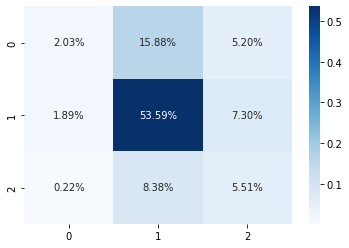

In [66]:
pred = svc1.predict(X_test)
score_pure_classification(pred_test, pred)

<b> Non-changed data standard scaler

In [67]:
svc2 = SVC(kernel = 'rbf', multiclass_strategy= 'ovr')
svc2.fit(X_train_st, pred_train)

SVC()

              precision    recall  f1-score   support

           0       0.13      0.17      0.15      5552
           1       0.72      0.67      0.70     23230
           2       0.36      0.36      0.36      5240

    accuracy                           0.54     34022
   macro avg       0.40      0.40      0.40     34022
weighted avg       0.57      0.54      0.55     34022

--------------------
The accuracy of the model is: 0.5419728411028158
--------------------
The f1-macro score for the model is: 0.4001028351578126
--------------------


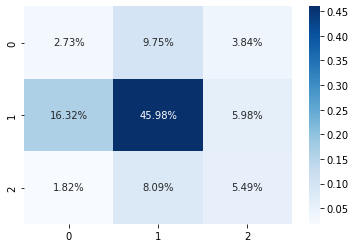

In [68]:
pred = svc2.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.23      0.21      0.22      7117
           1       0.63      0.64      0.63     19330
           2       0.35      0.39      0.37      4344

    accuracy                           0.50     30791
   macro avg       0.40      0.41      0.41     30791
weighted avg       0.50      0.50      0.50     30791

--------------------
The accuracy of the model is: 0.5031665096943913
--------------------
The f1-macro score for the model is: 0.40767363126065453
--------------------


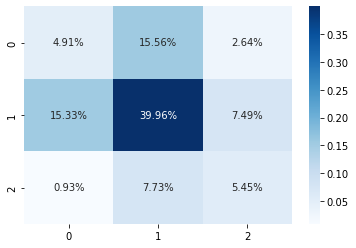

In [69]:
pred = svc2.predict(X_test_st)
score_pure_classification(pred_test, pred)

<b> Non-changed data minmax scaler

In [70]:
svc3 = SVC(kernel = 'rbf', multiclass_strategy= 'ovr')
svc3.fit(X_train_mm, pred_train)

SVC()

              precision    recall  f1-score   support

           0       0.38      0.20      0.26      5552
           1       0.74      0.81      0.77     23230
           2       0.31      0.33      0.32      5240

    accuracy                           0.64     34022
   macro avg       0.48      0.45      0.45     34022
weighted avg       0.61      0.64      0.62     34022

--------------------
The accuracy of the model is: 0.6382046910822409
--------------------
The f1-macro score for the model is: 0.45058491704007647
--------------------


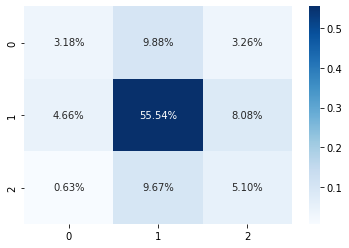

In [71]:
pred = svc3.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.24      0.07      0.11      7117
           1       0.67      0.82      0.74     19330
           2       0.35      0.39      0.37      4344

    accuracy                           0.59     30791
   macro avg       0.42      0.43      0.41     30791
weighted avg       0.52      0.59      0.54     30791

--------------------
The accuracy of the model is: 0.5885486018641811
--------------------
The f1-macro score for the model is: 0.4066919579120747
--------------------


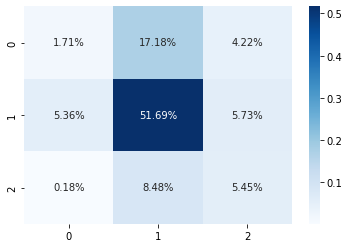

In [72]:
pred = svc3.predict(X_test_mm)
score_pure_classification(pred_test, pred)

<b> Undersampled data

In [74]:
svc4 = SVC(kernel = 'rbf', multiclass_strategy= 'ovr')
svc4.fit(X_train_under, pred_train_under)

SVC()

              precision    recall  f1-score   support

           0       0.27      0.66      0.38      5552
           1       0.80      0.51      0.62     23230
           2       0.33      0.36      0.35      5240

    accuracy                           0.51     34022
   macro avg       0.47      0.51      0.45     34022
weighted avg       0.64      0.51      0.54     34022

--------------------
The accuracy of the model is: 0.5110810651931104
--------------------
The f1-macro score for the model is: 0.4508946552229826
--------------------


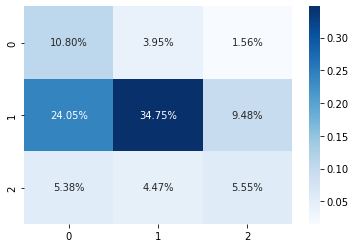

In [75]:
pred = svc4.predict(X_validation)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.29      0.30      0.30      7117
           1       0.69      0.57      0.62     19330
           2       0.28      0.49      0.35      4344

    accuracy                           0.49     30791
   macro avg       0.42      0.45      0.42     30791
weighted avg       0.54      0.49      0.51     30791

--------------------
The accuracy of the model is: 0.49352083400993796
--------------------
The f1-macro score for the model is: 0.42457749363682046
--------------------


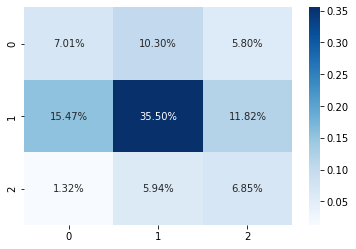

In [76]:
pred = svc4.predict(X_test)
score_pure_classification(pred_test, pred)

<b> Undersampled data standard scaler

In [78]:
svc5 = SVC(kernel = 'rbf', multiclass_strategy= 'ovr')
svc5.fit(X_train_under_st, pred_train_under)

SVC()

              precision    recall  f1-score   support

           0       0.12      0.26      0.17      5552
           1       0.71      0.48      0.57     23230
           2       0.33      0.41      0.37      5240

    accuracy                           0.43     34022
   macro avg       0.39      0.38      0.37     34022
weighted avg       0.55      0.43      0.47     34022

--------------------
The accuracy of the model is: 0.4326612192110987
--------------------
The f1-macro score for the model is: 0.3685322141422451
--------------------


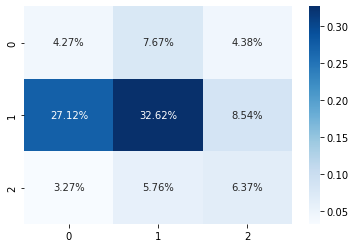

In [79]:
pred = svc5.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.25      0.33      0.28      7117
           1       0.63      0.49      0.55     19330
           2       0.32      0.47      0.38      4344

    accuracy                           0.45     30791
   macro avg       0.40      0.43      0.40     30791
weighted avg       0.50      0.45      0.47     30791

--------------------
The accuracy of the model is: 0.4494819914910201
--------------------
The f1-macro score for the model is: 0.4049752559770344
--------------------


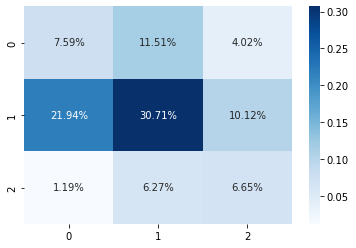

In [80]:
pred = svc5.predict(X_test_st)
score_pure_classification(pred_test, pred)

<b> Undersampled data minmax scaler

In [82]:
svc6 = SVC(kernel = 'rbf', multiclass_strategy= 'ovr')
svc6.fit(X_train_under_mm, pred_train_under)

SVC()

              precision    recall  f1-score   support

           0       0.19      0.54      0.28      5552
           1       0.75      0.35      0.48     23230
           2       0.31      0.45      0.37      5240

    accuracy                           0.39     34022
   macro avg       0.42      0.45      0.38     34022
weighted avg       0.59      0.39      0.43     34022

--------------------
The accuracy of the model is: 0.3948621480218682
--------------------
The f1-macro score for the model is: 0.37579401270149354
--------------------


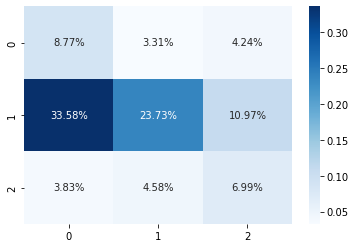

In [83]:
pred = svc6.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.24      0.30      0.27      7117
           1       0.69      0.51      0.59     19330
           2       0.35      0.64      0.45      4344

    accuracy                           0.48     30791
   macro avg       0.43      0.48      0.44     30791
weighted avg       0.54      0.48      0.49     30791

--------------------
The accuracy of the model is: 0.47789938618427463
--------------------
The f1-macro score for the model is: 0.43524661373380735
--------------------


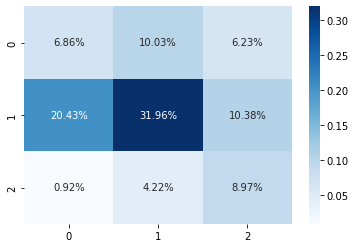

In [84]:
pred = svc6.predict(X_test_mm)
score_pure_classification(pred_test, pred)

### 5.3.2 Multiclass Logistic Regression OvR

<b> Non-changed data

In [85]:
ovr1 = OneVsRestClassifier(LogisticRegression())
ovr1.fit(X_train, pred_train)

OneVsRestClassifier()

              precision    recall  f1-score   support

           0       0.17      0.37      0.23      5552
           1       0.63      0.28      0.39     23230
           2       0.22      0.48      0.30      5240

    accuracy                           0.33     34022
   macro avg       0.34      0.38      0.31     34022
weighted avg       0.49      0.33      0.35     34022

--------------------
The accuracy of the model is: 0.3272294397742637
--------------------
The f1-macro score for the model is: 0.30753585494171704
--------------------


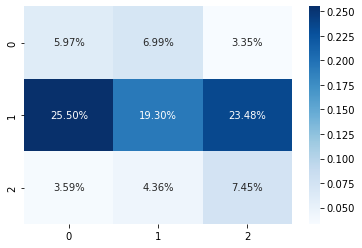

In [86]:
pred = ovr1.predict(X_validation)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.09      0.04      0.05      7117
           1       0.60      0.66      0.63     19330
           2       0.29      0.42      0.34      4344

    accuracy                           0.48     30791
   macro avg       0.32      0.37      0.34     30791
weighted avg       0.44      0.48      0.46     30791

--------------------
The accuracy of the model is: 0.4811470884349323
--------------------
The f1-macro score for the model is: 0.3412644205507099
--------------------


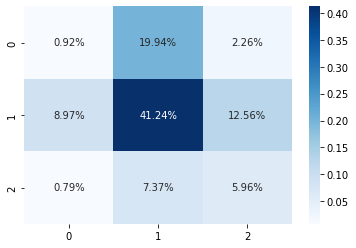

In [87]:
pred = ovr1.predict(X_test)
score_pure_classification(pred_test, pred)

<b> Non-changed data standard scaler

In [88]:
ovr2 = OneVsRestClassifier(LogisticRegression())
ovr2.fit(X_train_st, pred_train)

[W] [12:58:10.208279] L-BFGS: max iterations reached
[W] [12:58:10.208586] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [12:58:11.854876] L-BFGS: max iterations reached
[W] [12:58:11.855600] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [12:58:13.794081] L-BFGS: max iterations reached
[W] [12:58:13.794308] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


OneVsRestClassifier()

              precision    recall  f1-score   support

           0       0.24      0.37      0.29      5552
           1       0.78      0.60      0.68     23230
           2       0.31      0.45      0.37      5240

    accuracy                           0.54     34022
   macro avg       0.44      0.47      0.45     34022
weighted avg       0.62      0.54      0.57     34022

--------------------
The accuracy of the model is: 0.5395332431955794
--------------------
The f1-macro score for the model is: 0.4468417553869555
--------------------


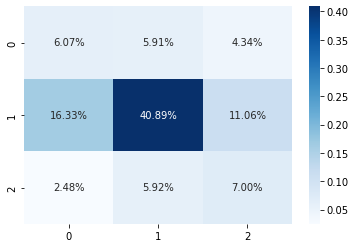

In [89]:
pred = ovr2.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.26      0.15      0.19      7117
           1       0.64      0.61      0.62     19330
           2       0.23      0.43      0.30      4344

    accuracy                           0.48     30791
   macro avg       0.38      0.40      0.37     30791
weighted avg       0.49      0.48      0.48     30791

--------------------
The accuracy of the model is: 0.47786690916176805
--------------------
The f1-macro score for the model is: 0.3723713135376248
--------------------


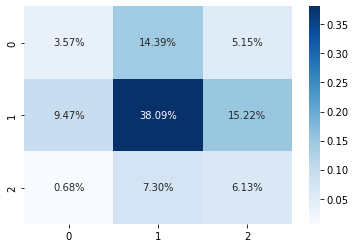

In [90]:
pred = ovr2.predict(X_test_st)
score_pure_classification(pred_test, pred)

<b> Non-changed data minmax scaler

In [91]:
ovr3 = OneVsRestClassifier(LogisticRegression())
ovr3.fit(X_train_mm, pred_train)

OneVsRestClassifier()

              precision    recall  f1-score   support

           0       0.23      0.34      0.28      5552
           1       0.76      0.60      0.67     23230
           2       0.30      0.43      0.36      5240

    accuracy                           0.53     34022
   macro avg       0.43      0.46      0.43     34022
weighted avg       0.61      0.53      0.56     34022

--------------------
The accuracy of the model is: 0.5335959085297749
--------------------
The f1-macro score for the model is: 0.43468157987110095
--------------------


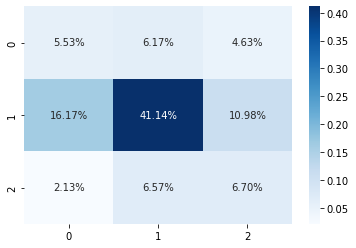

In [92]:
pred = ovr3.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.24      0.15      0.18      7117
           1       0.67      0.72      0.69     19330
           2       0.28      0.36      0.32      4344

    accuracy                           0.54     30791
   macro avg       0.40      0.41      0.40     30791
weighted avg       0.51      0.54      0.52     30791

--------------------
The accuracy of the model is: 0.5360007794485402
--------------------
The f1-macro score for the model is: 0.39694717861529893
--------------------


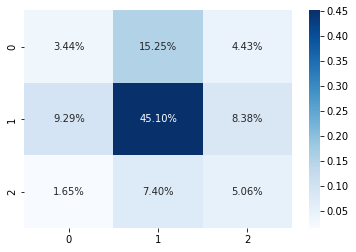

In [93]:
pred = ovr3.predict(X_test_mm)
score_pure_classification(pred_test, pred)

<b> Undersampled data

In [94]:
ovr4 = OneVsRestClassifier(LogisticRegression())
ovr4.fit(X_train_under, pred_train_under)

OneVsRestClassifier()

              precision    recall  f1-score   support

           0       0.20      0.52      0.29      5552
           1       0.68      0.15      0.25     23230
           2       0.23      0.61      0.33      5240

    accuracy                           0.29     34022
   macro avg       0.37      0.43      0.29     34022
weighted avg       0.53      0.29      0.27     34022

--------------------
The accuracy of the model is: 0.28560931162189174
--------------------
The f1-macro score for the model is: 0.2907221626944187
--------------------


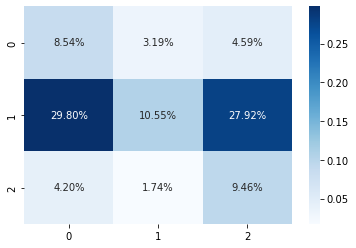

In [95]:
pred = ovr4.predict(X_validation)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.25      0.26      0.26      7117
           1       0.66      0.40      0.50     19330
           2       0.26      0.67      0.37      4344

    accuracy                           0.41     30791
   macro avg       0.39      0.45      0.38     30791
weighted avg       0.51      0.41      0.43     30791

--------------------
The accuracy of the model is: 0.40927543762787827
--------------------
The f1-macro score for the model is: 0.3756429002899302
--------------------


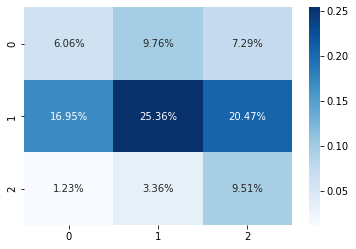

In [96]:
pred = ovr4.predict(X_test)
score_pure_classification(pred_test, pred)

<b> Undersampled data standard scaler

In [97]:
ovr5 = OneVsRestClassifier(LogisticRegression())
ovr5.fit(X_train_under_st, pred_train_under)

[W] [13:00:01.616648] L-BFGS: max iterations reached
[W] [13:00:01.617175] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:00:03.061919] L-BFGS: max iterations reached
[W] [13:00:03.062677] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


OneVsRestClassifier()

              precision    recall  f1-score   support

           0       0.20      0.51      0.29      5552
           1       0.79      0.32      0.46     23230
           2       0.28      0.56      0.37      5240

    accuracy                           0.39     34022
   macro avg       0.42      0.46      0.37     34022
weighted avg       0.62      0.39      0.42     34022

--------------------
The accuracy of the model is: 0.3873082123331962
--------------------
The f1-macro score for the model is: 0.37181403040873356
--------------------


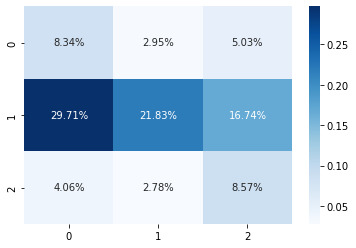

In [98]:
pred = ovr5.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.26      0.36      0.31      7117
           1       0.65      0.36      0.46     19330
           2       0.23      0.55      0.32      4344

    accuracy                           0.39     30791
   macro avg       0.38      0.42      0.36     30791
weighted avg       0.50      0.39      0.41     30791

--------------------
The accuracy of the model is: 0.386054366535676
--------------------
The f1-macro score for the model is: 0.36357580488855373
--------------------


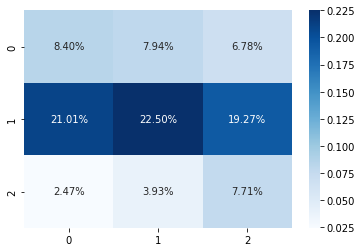

In [99]:
pred = ovr5.predict(X_test_st)
score_pure_classification(pred_test, pred)

<b> Undersampled data minmax scaler

In [100]:
ovr6 = OneVsRestClassifier(LogisticRegression())
ovr6.fit(X_train_under_mm, pred_train_under)

OneVsRestClassifier()

              precision    recall  f1-score   support

           0       0.19      0.51      0.28      5552
           1       0.77      0.33      0.46     23230
           2       0.29      0.52      0.37      5240

    accuracy                           0.39     34022
   macro avg       0.42      0.45      0.37     34022
weighted avg       0.60      0.39      0.42     34022

--------------------
The accuracy of the model is: 0.3859561460231615
--------------------
The f1-macro score for the model is: 0.3692528060060298
--------------------


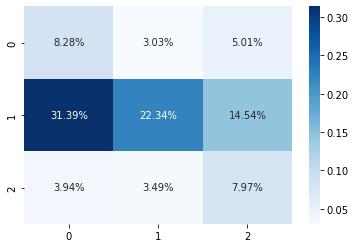

In [101]:
pred = ovr6.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7117
           1       0.00      0.00      0.00     19330
           2       0.14      1.00      0.25      4344

    accuracy                           0.14     30791
   macro avg       0.05      0.33      0.08     30791
weighted avg       0.02      0.14      0.03     30791

--------------------
The accuracy of the model is: 0.14108018576856873
--------------------
The f1-macro score for the model is: 0.08242493240358617
--------------------


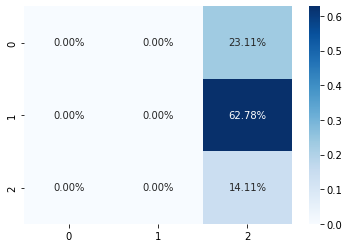

In [102]:
pred = ovr5.predict(X_test_mm)
score_pure_classification(pred_test, pred)

## 5.4 Ensemble

### 5.4.1 Classification Ensemble

In [103]:
rf = rfCMC(n_estimators=500, n_bins = 256, split_criterion= 1)
xgb = XGBClassifier(tree_method = 'gpu_hist', n_estimators = 500)
lgbm = lgb.LGBMClassifier(objective="multiclass",device='gpu',n_estimators=16,learning_rate=0.07,
                           num_leaves=2591,max_depth=10,min_data_in_leaf=6140,
                           lambda_l1=16,lambda_l2=17,
                           min_gain_to_split=6.09,bagging_fraction=0.9,bagging_freq=1,feature_fraction=0.2)

<b> Non-changed data

In [104]:
ensc1 = VotingClassifier(estimators=[('rf', rf), ('lgbm', lgbm), ('xgb', xgb)], voting='hard')
ensc1.fit(X_train, pred_train)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] min_gain_to_split is set=6.09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.09
[LightGBM] [Warning] min_data_in_leaf is set=6140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6140
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=17, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17


VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('lgbm',
                              LGBMClassifier(bagging_fraction=0.9,
                                             bagging_freq=1, device='gpu',
                                             feature_fraction=0.2, lambda_l1=16,
                                             lambda_l2=17, learning_rate=0.07,
                                             max_depth=10,
                                             min_data_in_leaf=6140,
                                             min_gain_to_split=6.09,
                                             n_estimators=16, num_leaves=2591,
                                             objective='multiclass')),
                             ('xgb',
                              XGBClassifier(base_score=None...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
          

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.50      0.38      0.43      5552
           1       0.78      0.80      0.79     23230
           2       0.34      0.39      0.36      5240

    accuracy                           0.67     34022
   macro avg       0.54      0.52      0.53     34022
weighted avg       0.67      0.67      0.66     34022

--------------------
The accuracy of the model is: 0.6654223737581565
--------------------
The f1-macro score for the model is: 0.5271768339883884
--------------------


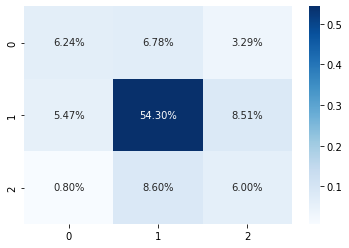

In [105]:
pred = ensc1.predict(X_validation)
score_pure_classification(pred_validation, pred)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.21      0.15      0.18      7117
           1       0.68      0.72      0.70     19330
           2       0.51      0.57      0.54      4344

    accuracy                           0.57     30791
   macro avg       0.46      0.48      0.47     30791
weighted avg       0.54      0.57      0.55     30791

--------------------
The accuracy of the model is: 0.5678607385274917
--------------------
The f1-macro score for the model is: 0.47002993758464723
--------------------


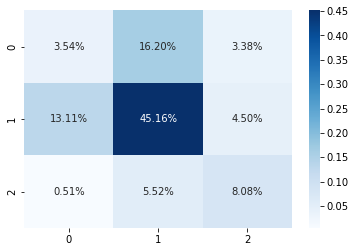

In [106]:
pred = ensc1.predict(X_test)
score_pure_classification(pred_test, pred)

<b> Non-changed data standard scaler

In [107]:
ensc2 = VotingClassifier(estimators=[('rf', rf), ('lgbm', lgbm), ('xgb', xgb)], voting='hard')
ensc2.fit(X_train_st, pred_train)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] min_gain_to_split is set=6.09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.09
[LightGBM] [Warning] min_data_in_leaf is set=6140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6140
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=17, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17


VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('lgbm',
                              LGBMClassifier(bagging_fraction=0.9,
                                             bagging_freq=1, device='gpu',
                                             feature_fraction=0.2, lambda_l1=16,
                                             lambda_l2=17, learning_rate=0.07,
                                             max_depth=10,
                                             min_data_in_leaf=6140,
                                             min_gain_to_split=6.09,
                                             n_estimators=16, num_leaves=2591,
                                             objective='multiclass')),
                             ('xgb',
                              XGBClassifier(base_score=None...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
          

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.49      0.34      0.40      5552
           1       0.77      0.80      0.79     23230
           2       0.33      0.39      0.36      5240

    accuracy                           0.66     34022
   macro avg       0.53      0.51      0.52     34022
weighted avg       0.66      0.66      0.66     34022

--------------------
The accuracy of the model is: 0.6621303862206808
--------------------
The f1-macro score for the model is: 0.5167822619576928
--------------------


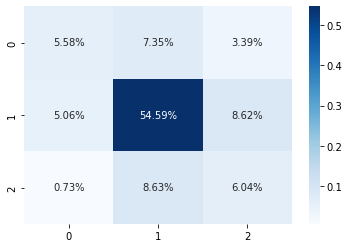

In [108]:
pred = ensc2.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.21      0.16      0.18      7117
           1       0.68      0.72      0.70     19330
           2       0.51      0.57      0.54      4344

    accuracy                           0.57     30791
   macro avg       0.47      0.48      0.47     30791
weighted avg       0.55      0.57      0.56     30791

--------------------
The accuracy of the model is: 0.569224773472768
--------------------
The f1-macro score for the model is: 0.47239371836674054
--------------------


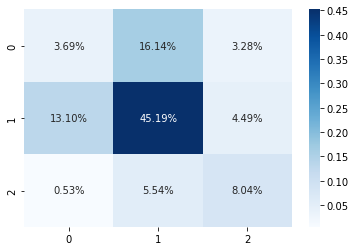

In [109]:
pred = ensc2.predict(X_test_st)
score_pure_classification(pred_test, pred)

<b> Non-changed data minmax scaler

In [110]:
ensc3 = VotingClassifier(estimators=[('rf', rf), ('lgbm', lgbm), ('xgb', xgb)], voting='hard')
ensc3.fit(X_train_mm, pred_train)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] min_gain_to_split is set=6.09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.09
[LightGBM] [Warning] min_data_in_leaf is set=6140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6140
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=17, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17


VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('lgbm',
                              LGBMClassifier(bagging_fraction=0.9,
                                             bagging_freq=1, device='gpu',
                                             feature_fraction=0.2, lambda_l1=16,
                                             lambda_l2=17, learning_rate=0.07,
                                             max_depth=10,
                                             min_data_in_leaf=6140,
                                             min_gain_to_split=6.09,
                                             n_estimators=16, num_leaves=2591,
                                             objective='multiclass')),
                             ('xgb',
                              XGBClassifier(base_score=None...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
          

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.50      0.37      0.42      5552
           1       0.78      0.80      0.79     23230
           2       0.33      0.39      0.36      5240

    accuracy                           0.66     34022
   macro avg       0.54      0.52      0.52     34022
weighted avg       0.66      0.66      0.66     34022

--------------------
The accuracy of the model is: 0.6640997001939921
--------------------
The f1-macro score for the model is: 0.5240863036195296
--------------------


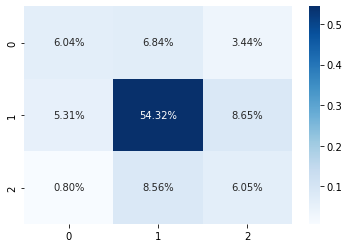

In [111]:
pred = ensc3.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.22      0.16      0.19      7117
           1       0.68      0.72      0.70     19330
           2       0.51      0.57      0.54      4344

    accuracy                           0.57     30791
   macro avg       0.47      0.48      0.47     30791
weighted avg       0.55      0.57      0.56     30791

--------------------
The accuracy of the model is: 0.5684778019551168
--------------------
The f1-macro score for the model is: 0.47304563260600574
--------------------


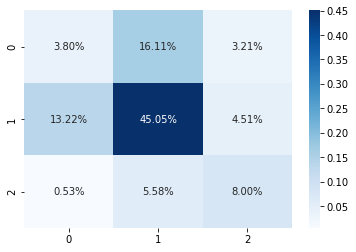

In [112]:
pred = ensc3.predict(X_test_mm)
score_pure_classification(pred_test, pred)

<b> Undersampled data

In [113]:
ensc4 = VotingClassifier(estimators=[('rf', rf), ('lgbm', lgbm), ('xgb', xgb)], voting='hard')
ensc4.fit(X_train_under, pred_train_under)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] min_gain_to_split is set=6.09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.09
[LightGBM] [Warning] min_data_in_leaf is set=6140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6140
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=17, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17


VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('lgbm',
                              LGBMClassifier(bagging_fraction=0.9,
                                             bagging_freq=1, device='gpu',
                                             feature_fraction=0.2, lambda_l1=16,
                                             lambda_l2=17, learning_rate=0.07,
                                             max_depth=10,
                                             min_data_in_leaf=6140,
                                             min_gain_to_split=6.09,
                                             n_estimators=16, num_leaves=2591,
                                             objective='multiclass')),
                             ('xgb',
                              XGBClassifier(base_score=None...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
          

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.33      0.56      0.41      5552
           1       0.82      0.58      0.68     23230
           2       0.33      0.52      0.40      5240

    accuracy                           0.57     34022
   macro avg       0.49      0.55      0.50     34022
weighted avg       0.66      0.57      0.59     34022

--------------------
The accuracy of the model is: 0.5654576450532008
--------------------
The f1-macro score for the model is: 0.4976100831351562
--------------------


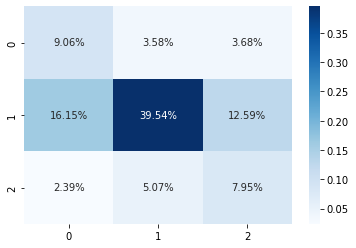

In [114]:
pred = ensc4.predict(X_validation)
score_pure_classification(pred_validation, pred)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.25      0.32      0.28      7117
           1       0.69      0.55      0.61     19330
           2       0.44      0.64      0.52      4344

    accuracy                           0.51     30791
   macro avg       0.46      0.50      0.47     30791
weighted avg       0.55      0.51      0.52     30791

--------------------
The accuracy of the model is: 0.5050176999772661
--------------------
The f1-macro score for the model is: 0.4679199819422921
--------------------


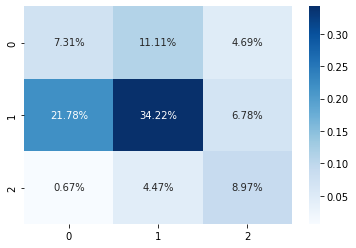

In [115]:
pred = ensc4.predict(X_test)
score_pure_classification(pred_test, pred)

<b> Undersampled data standard scaled

In [116]:
ensc5 = VotingClassifier(estimators=[('rf', rf), ('lgbm', lgbm), ('xgb', xgb)], voting='hard')
ensc5.fit(X_train_under_st, pred_train_under)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] min_gain_to_split is set=6.09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.09
[LightGBM] [Warning] min_data_in_leaf is set=6140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6140
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=17, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17


VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('lgbm',
                              LGBMClassifier(bagging_fraction=0.9,
                                             bagging_freq=1, device='gpu',
                                             feature_fraction=0.2, lambda_l1=16,
                                             lambda_l2=17, learning_rate=0.07,
                                             max_depth=10,
                                             min_data_in_leaf=6140,
                                             min_gain_to_split=6.09,
                                             n_estimators=16, num_leaves=2591,
                                             objective='multiclass')),
                             ('xgb',
                              XGBClassifier(base_score=None...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
          

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.33      0.56      0.41      5552
           1       0.82      0.58      0.68     23230
           2       0.33      0.52      0.40      5240

    accuracy                           0.56     34022
   macro avg       0.49      0.55      0.50     34022
weighted avg       0.67      0.56      0.59     34022

--------------------
The accuracy of the model is: 0.5643995062018694
--------------------
The f1-macro score for the model is: 0.49792115832482775
--------------------


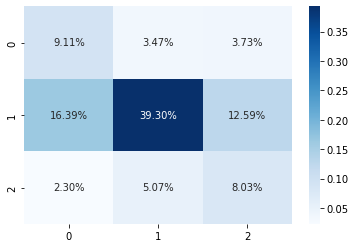

In [117]:
pred = ensc5.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.25      0.32      0.28      7117
           1       0.69      0.55      0.61     19330
           2       0.44      0.64      0.52      4344

    accuracy                           0.51     30791
   macro avg       0.46      0.50      0.47     30791
weighted avg       0.55      0.51      0.52     30791

--------------------
The accuracy of the model is: 0.5062193498100094
--------------------
The f1-macro score for the model is: 0.46858354455515694
--------------------


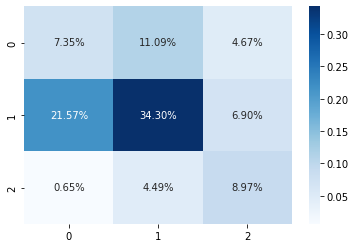

In [118]:
pred = ensc5.predict(X_test_st)
score_pure_classification(pred_test, pred)

<b> Undersampled data minmax scaled

In [119]:
ensc6 = VotingClassifier(estimators=[('rf', rf), ('lgbm', lgbm), ('xgb', xgb)], voting='hard')
ensc6.fit(X_train_under_mm, pred_train_under)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] min_gain_to_split is set=6.09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.09
[LightGBM] [Warning] min_data_in_leaf is set=6140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6140
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=17, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17


VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('lgbm',
                              LGBMClassifier(bagging_fraction=0.9,
                                             bagging_freq=1, device='gpu',
                                             feature_fraction=0.2, lambda_l1=16,
                                             lambda_l2=17, learning_rate=0.07,
                                             max_depth=10,
                                             min_data_in_leaf=6140,
                                             min_gain_to_split=6.09,
                                             n_estimators=16, num_leaves=2591,
                                             objective='multiclass')),
                             ('xgb',
                              XGBClassifier(base_score=None...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
          

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.33      0.57      0.42      5552
           1       0.82      0.58      0.68     23230
           2       0.33      0.52      0.40      5240

    accuracy                           0.57     34022
   macro avg       0.50      0.55      0.50     34022
weighted avg       0.67      0.57      0.60     34022

--------------------
The accuracy of the model is: 0.5689553818117689
--------------------
The f1-macro score for the model is: 0.5013709503686198
--------------------


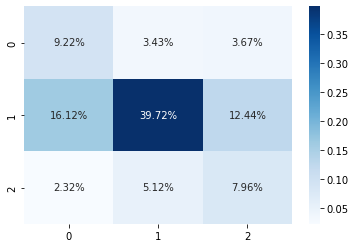

In [120]:
pred = ensc6.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.24      0.97      0.38      7117
           1       0.70      0.06      0.11     19330
           2       0.57      0.08      0.13      4344

    accuracy                           0.27     30791
   macro avg       0.50      0.37      0.21     30791
weighted avg       0.58      0.27      0.18     30791

--------------------
The accuracy of the model is: 0.2704686434347699
--------------------
The f1-macro score for the model is: 0.2088463556311793
--------------------


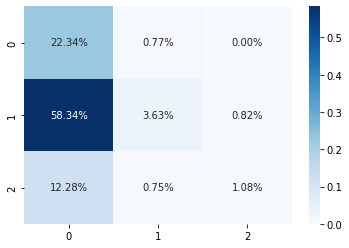

In [121]:
pred = ensc5.predict(X_test_mm)
score_pure_classification(pred_test, pred)

### 5.4.2 Regression Ensemble

In [122]:
rf = rfCMR(n_estimators=1000, n_bins = 256, split_criterion= 6)
xgb = XGBRegressor(tree_method = 'gpu_hist', n_estimators = 500)
lgbm = lgb.LGBMRegressor(n_estimators=18,learning_rate=0.18,num_leaves= 2420,max_depth= 3,min_data_in_leaf= 1600,lambda_l1= 0.27,lambda_l2= 62,
min_gain_to_split= 7.02,bagging_fraction= 0.5,bagging_freq=1,feature_fraction= 0.3,device='gpu',objective='regression',metric='l2')

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:794: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return func(**kwargs)


<b> Non-changed data

In [123]:
ensr1 = VotingRegressor(estimators=[('rf', rf), ('lgbm', lgbm), ('xgb', xgb)])
ensr1.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.27, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27
[LightGBM] [Warning] min_gain_to_split is set=7.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.02
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=62, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62


VotingRegressor(estimators=[('rf', RandomForestRegressor()),
                            ('lgbm',
                             LGBMRegressor(bagging_fraction=0.5, bagging_freq=1,
                                           device='gpu', feature_fraction=0.3,
                                           lambda_l1=0.27, lambda_l2=62,
                                           learning_rate=0.18, max_depth=3,
                                           metric='l2', min_data_in_leaf=1600,
                                           min_gain_to_split=7.02,
                                           n_estimators=18, num_leaves=2420,
                                           objective='regression')),
                            ('xgb',
                             XGBRegressor(base_s...
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
    

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.3114566443676547
--------------------
Mean squared error: 3.0268969482377157
--------------------
Root mean squared error: 1.739797961901817
--------------------
R2 score: 0.09735094815394141
--------------------
              precision    recall  f1-score   support

           0       0.41      0.30      0.35      5552
           1       0.71      0.90      0.80     23230
           2       0.71      0.08      0.14      5240

    accuracy                           0.68     34022
   macro avg       0.61      0.43      0.43     34022
weighted avg       0.66      0.68      0.62     34022

--------------------
The accuracy of the model is: 0.6762389042384339
--------------------
The f1-macro score for the model is: 0.42983769395256277
--------------------


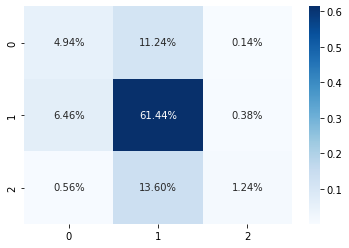

In [124]:
pred = ensr1.predict(X_validation)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.3114898787162799
--------------------
Mean squared error: 2.8709915559730237
--------------------
Root mean squared error: 1.6944000578296212
--------------------
R2 score: 0.026337218607300095
--------------------
              precision    recall  f1-score   support

           0       0.23      0.14      0.17      7117
           1       0.62      0.82      0.71     19330
           2       0.69      0.19      0.29      4344

    accuracy                           0.57     30791
   macro avg       0.52      0.38      0.39     30791
weighted avg       0.54      0.57      0.53     30791

--------------------
The accuracy of the model is: 0.5721152284758534
--------------------
The f1-macro score for the model is: 0.39055228809923004
--------------------


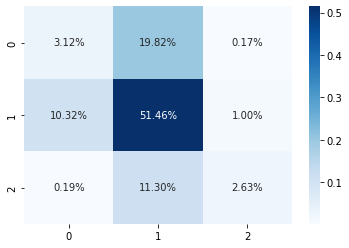

In [125]:
pred = ensr1.predict(X_test)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Non-changed data standard scaler

In [126]:
ensr2 = VotingRegressor(estimators=[('rf', rf), ('lgbm', lgbm), ('xgb', xgb)])
ensr2.fit(X_train_st,y_train)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.27, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27
[LightGBM] [Warning] min_gain_to_split is set=7.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.02
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=62, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62


VotingRegressor(estimators=[('rf', RandomForestRegressor()),
                            ('lgbm',
                             LGBMRegressor(bagging_fraction=0.5, bagging_freq=1,
                                           device='gpu', feature_fraction=0.3,
                                           lambda_l1=0.27, lambda_l2=62,
                                           learning_rate=0.18, max_depth=3,
                                           metric='l2', min_data_in_leaf=1600,
                                           min_gain_to_split=7.02,
                                           n_estimators=18, num_leaves=2420,
                                           objective='regression')),
                            ('xgb',
                             XGBRegressor(base_s...
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
    

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.3172299897134336
--------------------
Mean squared error: 3.0273484556493
--------------------
Root mean squared error: 1.7399277156391584
--------------------
R2 score: 0.09721630441022067
--------------------
              precision    recall  f1-score   support

           0       0.39      0.31      0.35      5552
           1       0.71      0.89      0.79     23230
           2       0.72      0.08      0.15      5240

    accuracy                           0.67     34022
   macro avg       0.61      0.43      0.43     34022
weighted avg       0.66      0.67      0.62     34022

--------------------
The accuracy of the model is: 0.6706542825230734
--------------------
The f1-macro score for the model is: 0.42967542095231254
--------------------


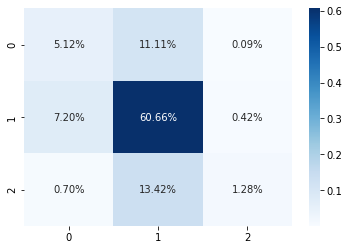

In [127]:
pred = ensr2.predict(X_validation_st)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.3225120219832578
--------------------
Mean squared error: 2.8710168516038257
--------------------
Root mean squared error: 1.6944075222932131
--------------------
R2 score: 0.026328639893722028
--------------------
              precision    recall  f1-score   support

           0       0.21      0.13      0.16      7117
           1       0.62      0.80      0.70     19330
           2       0.67      0.18      0.28      4344

    accuracy                           0.56     30791
   macro avg       0.50      0.37      0.38     30791
weighted avg       0.53      0.56      0.52     30791

--------------------
The accuracy of the model is: 0.5599363450358871
--------------------
The f1-macro score for the model is: 0.38108433056796853
--------------------


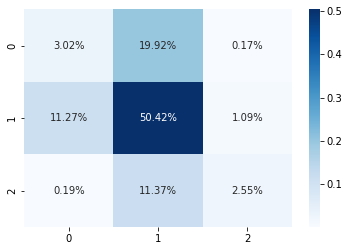

In [128]:
pred = ensr2.predict(X_test_st)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Non-changed data minmax scaler

In [129]:
ensr3 = VotingRegressor(estimators=[('rf', rf), ('lgbm', lgbm), ('xgb', xgb)])
ensr3.fit(X_train_mm,y_train)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.27, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27
[LightGBM] [Warning] min_gain_to_split is set=7.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.02
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=62, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62


VotingRegressor(estimators=[('rf', RandomForestRegressor()),
                            ('lgbm',
                             LGBMRegressor(bagging_fraction=0.5, bagging_freq=1,
                                           device='gpu', feature_fraction=0.3,
                                           lambda_l1=0.27, lambda_l2=62,
                                           learning_rate=0.18, max_depth=3,
                                           metric='l2', min_data_in_leaf=1600,
                                           min_gain_to_split=7.02,
                                           n_estimators=18, num_leaves=2420,
                                           objective='regression')),
                            ('xgb',
                             XGBRegressor(base_s...
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
    

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.3119931598948813
--------------------
Mean squared error: 3.011681495856683
--------------------
Root mean squared error: 1.7354196886795663
--------------------
R2 score: 0.1018883387225713
--------------------
              precision    recall  f1-score   support

           0       0.38      0.33      0.35      5552
           1       0.71      0.88      0.79     23230
           2       0.65      0.07      0.13      5240

    accuracy                           0.66     34022
   macro avg       0.58      0.43      0.42     34022
weighted avg       0.65      0.66      0.61     34022

--------------------
The accuracy of the model is: 0.6638939509728999
--------------------
The f1-macro score for the model is: 0.42298158394715574
--------------------


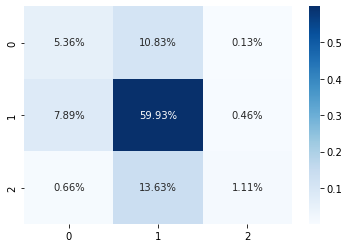

In [130]:
pred = ensr3.predict(X_validation_mm)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.3114326326674468
--------------------
Mean squared error: 2.832300937156187
--------------------
Root mean squared error: 1.6829441277583124
--------------------
R2 score: 0.03945868371667349
--------------------
              precision    recall  f1-score   support

           0       0.21      0.13      0.16      7117
           1       0.62      0.82      0.70     19330
           2       0.69      0.16      0.26      4344

    accuracy                           0.56     30791
   macro avg       0.51      0.37      0.38     30791
weighted avg       0.54      0.56      0.52     30791

--------------------
The accuracy of the model is: 0.5649702835244065
--------------------
The f1-macro score for the model is: 0.3763832803910579
--------------------


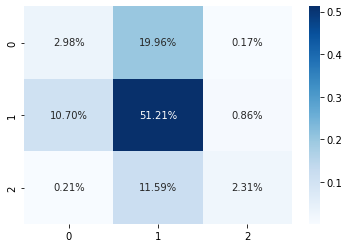

In [131]:
pred = ensr3.predict(X_test_mm)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Undersampled data

In [132]:
ensr4 = VotingRegressor(estimators=[('rf', rf), ('lgbm', lgbm), ('xgb', xgb)])
ensr4.fit(X_train_under,y_train_under)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.27, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27
[LightGBM] [Warning] min_gain_to_split is set=7.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.02
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=62, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62


VotingRegressor(estimators=[('rf', RandomForestRegressor()),
                            ('lgbm',
                             LGBMRegressor(bagging_fraction=0.5, bagging_freq=1,
                                           device='gpu', feature_fraction=0.3,
                                           lambda_l1=0.27, lambda_l2=62,
                                           learning_rate=0.18, max_depth=3,
                                           metric='l2', min_data_in_leaf=1600,
                                           min_gain_to_split=7.02,
                                           n_estimators=18, num_leaves=2420,
                                           objective='regression')),
                            ('xgb',
                             XGBRegressor(base_s...
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
    

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.3580586563384374
--------------------
Mean squared error: 3.1206275313683465
--------------------
Root mean squared error: 1.7665297991736075
--------------------
R2 score: 0.06939960939392842
--------------------
              precision    recall  f1-score   support

           0       0.34      0.39      0.36      5552
           1       0.71      0.82      0.76     23230
           2       0.65      0.10      0.17      5240

    accuracy                           0.64     34022
   macro avg       0.57      0.44      0.43     34022
weighted avg       0.64      0.64      0.61     34022

--------------------
The accuracy of the model is: 0.6394979719005349
--------------------
The f1-macro score for the model is: 0.43255111500159527
--------------------


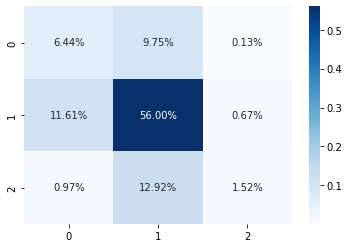

In [133]:
pred = ensr4.predict(X_validation)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.3272602174958479
--------------------
Mean squared error: 2.8204162782657294
--------------------
Root mean squared error: 1.6794095028508471
--------------------
R2 score: 0.0434892250141955
--------------------
              precision    recall  f1-score   support

           0       0.21      0.19      0.20      7117
           1       0.61      0.74      0.66     19330
           2       0.72      0.17      0.28      4344

    accuracy                           0.53     30791
   macro avg       0.51      0.36      0.38     30791
weighted avg       0.53      0.53      0.50     30791

--------------------
The accuracy of the model is: 0.5291156506771459
--------------------
The f1-macro score for the model is: 0.3803851685972088
--------------------


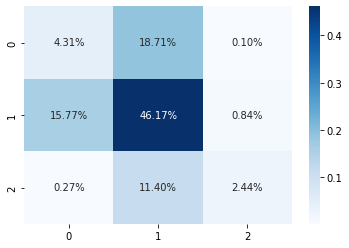

In [134]:
pred = ensr4.predict(X_test)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Undersampled data standard scaler

In [135]:
ensr5 = VotingRegressor(estimators=[('rf', rf), ('lgbm', lgbm), ('xgb', xgb)])
ensr5.fit(X_train_under_st,y_train_under)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.27, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27
[LightGBM] [Warning] min_gain_to_split is set=7.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.02
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=62, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62


VotingRegressor(estimators=[('rf', RandomForestRegressor()),
                            ('lgbm',
                             LGBMRegressor(bagging_fraction=0.5, bagging_freq=1,
                                           device='gpu', feature_fraction=0.3,
                                           lambda_l1=0.27, lambda_l2=62,
                                           learning_rate=0.18, max_depth=3,
                                           metric='l2', min_data_in_leaf=1600,
                                           min_gain_to_split=7.02,
                                           n_estimators=18, num_leaves=2420,
                                           objective='regression')),
                            ('xgb',
                             XGBRegressor(base_s...
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
    

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.3688480259860696
--------------------
Mean squared error: 3.1206506202486124
--------------------
Root mean squared error: 1.766536334256562
--------------------
R2 score: 0.06939272407333885
--------------------
              precision    recall  f1-score   support

           0       0.31      0.38      0.34      5552
           1       0.70      0.80      0.75     23230
           2       0.74      0.09      0.17      5240

    accuracy                           0.62     34022
   macro avg       0.58      0.43      0.42     34022
weighted avg       0.64      0.62      0.59     34022

--------------------
The accuracy of the model is: 0.6243901005231909
--------------------
The f1-macro score for the model is: 0.41914867976928316
--------------------


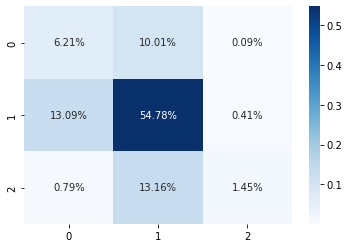

In [136]:
pred = ensr5.predict(X_validation_st)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.3435219948617758
--------------------
Mean squared error: 2.8658725445020576
--------------------
Root mean squared error: 1.692888816343843
--------------------
R2 score: 0.028073270716694965
--------------------
              precision    recall  f1-score   support

           0       0.21      0.18      0.19      7117
           1       0.60      0.74      0.66     19330
           2       0.70      0.16      0.26      4344

    accuracy                           0.53     30791
   macro avg       0.50      0.36      0.37     30791
weighted avg       0.53      0.53      0.50     30791

--------------------
The accuracy of the model is: 0.5275567535968303
--------------------
The f1-macro score for the model is: 0.37316970200480526
--------------------


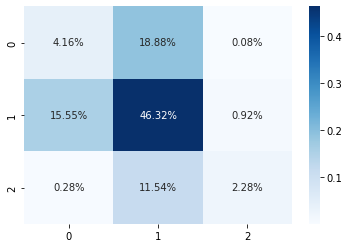

In [137]:
pred = ensr5.predict(X_test_st)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

<b> Undersampled data minmax scaler

In [138]:
ensr6 = VotingRegressor(estimators=[('rf', rf), ('lgbm', lgbm), ('xgb', xgb)])
ensr6.fit(X_train_under_mm,y_train_under)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.27, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27
[LightGBM] [Warning] min_gain_to_split is set=7.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.02
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=62, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62


VotingRegressor(estimators=[('rf', RandomForestRegressor()),
                            ('lgbm',
                             LGBMRegressor(bagging_fraction=0.5, bagging_freq=1,
                                           device='gpu', feature_fraction=0.3,
                                           lambda_l1=0.27, lambda_l2=62,
                                           learning_rate=0.18, max_depth=3,
                                           metric='l2', min_data_in_leaf=1600,
                                           min_gain_to_split=7.02,
                                           n_estimators=18, num_leaves=2420,
                                           objective='regression')),
                            ('xgb',
                             XGBRegressor(base_s...
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
    

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.381464090917413
--------------------
Mean squared error: 3.1622341542239742
--------------------
Root mean squared error: 1.7782671774016339
--------------------
R2 score: 0.05699212433137468
--------------------
              precision    recall  f1-score   support

           0       0.32      0.40      0.35      5552
           1       0.71      0.80      0.75     23230
           2       0.62      0.09      0.15      5240

    accuracy                           0.62     34022
   macro avg       0.55      0.43      0.42     34022
weighted avg       0.63      0.62      0.59     34022

--------------------
The accuracy of the model is: 0.6235083181470813
--------------------
The f1-macro score for the model is: 0.4191592441298366
--------------------


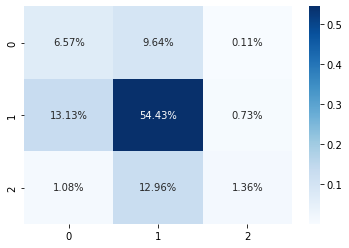

In [139]:
pred = ensr6.predict(X_validation_mm)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Mean absolute error:  1.4142736262967606
--------------------
Mean squared error: 3.383900107300353
--------------------
Root mean squared error: 1.839538014638554
--------------------
R2 score: -0.14760964154506762
--------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7117
           1       0.63      1.00      0.77     19330
           2       0.00      0.00      0.00      4344

    accuracy                           0.63     30791
   macro avg       0.21      0.33      0.26     30791
weighted avg       0.39      0.63      0.48     30791

--------------------
The accuracy of the model is: 0.6277808450521256
--------------------
The f1-macro score for the model is: 0.25711112441225564
--------------------


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


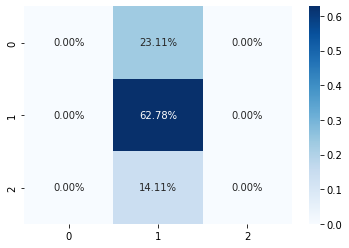

In [140]:
pred = ensr5.predict(X_test_mm)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))